# Try Out

In [1]:
from torch.autograd import Variable

from torch.nn import functional as F

import VAE_NN
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import torch

from torch.optim import Adam, Adagrad

import seaborn as sns

import time
%config InlineBackend.figure_format = 'retina'

In [86]:
test = VAE_NN.VAE_Net(latent_size=20,conditional=True,fast=True)

In [2]:
train_data,test_data = VAE_NN.get_data_loaders(b_size=100)

In [88]:
test.load_state_dict(torch.load('../ModelWeights/MNIST_20D_100e_C'))

In [89]:
test.cuda()

VAE_Net(
  (ei): Linear(in_features=794, out_features=500)
  (em): Linear(in_features=500, out_features=20)
  (ev): Linear(in_features=500, out_features=20)
  (di): Linear(in_features=30, out_features=500)
  (dom): Linear(in_features=500, out_features=784)
)

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [91]:
t_data,label = next(iter(train_data))

In [92]:
t_data = Variable(t_data).view(-1,784)

In [93]:
ohc = OneHotEncoder(sparse=False)

In [94]:
label_n = label.numpy()

In [95]:
label_r = label_n.reshape(len(label_n), 1)

In [96]:
label_ohc = Variable(torch.Tensor(ohc.fit_transform(label_r)))

In [97]:
data = torch.cat([t_data,label_ohc],dim=1)

In [98]:
i = 3

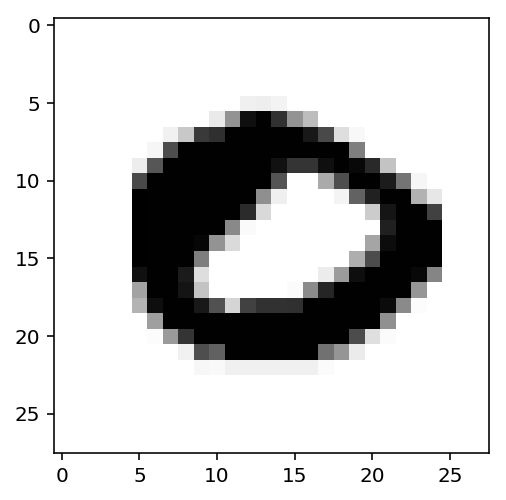

In [99]:
plt.imshow(np.reshape(t_data[i].data.cpu().numpy(),(28,28)), cmap='gray_r')
plt.show()

Try to reconstruct the above:

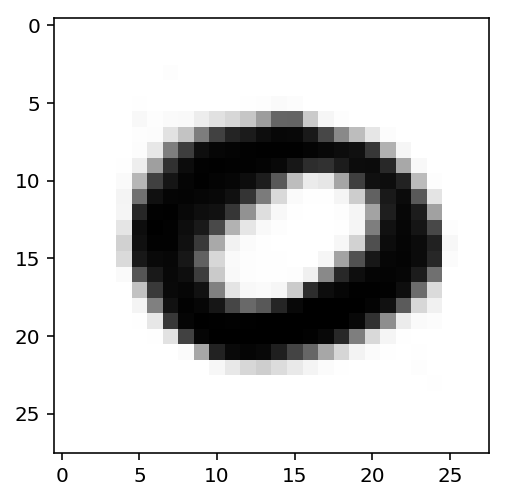

In [100]:
a,_,b,c = test(data[i:i+1].cuda())

im_t = a[0,:]

im_t = im_t.data.cpu().numpy()

plt.imshow(np.reshape(im_t,(28,28)),cmap='gray_r')
plt.show()

Keep noise the same:

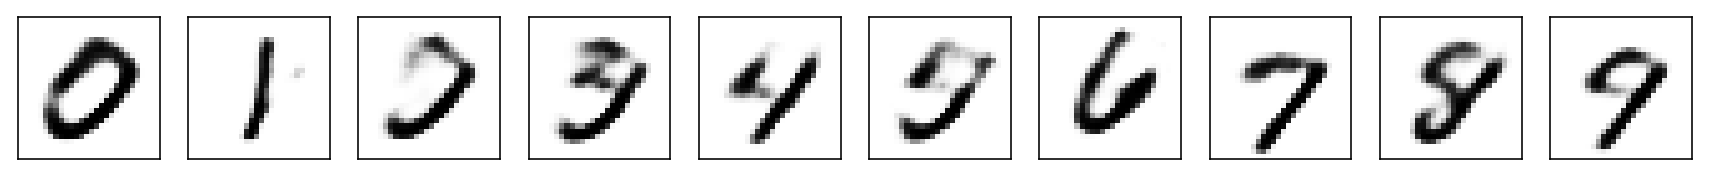

In [104]:
f, axarr = plt.subplots(1, 10,figsize=(15,15))

noise = test.sample()

for i in range(10):
    
    ohc = [0]*10
    ohc[i] = 1
    
    ohc = Variable(torch.Tensor(ohc)).cuda()
    
    a,b = test.decode(torch.cat([noise,ohc],dim=0))

    im_t = a

    im_t = im_t.data.cpu().numpy()

    axarr[i].imshow(np.reshape(im_t,(28,28)),cmap='gray_r')
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
    
plt.show()

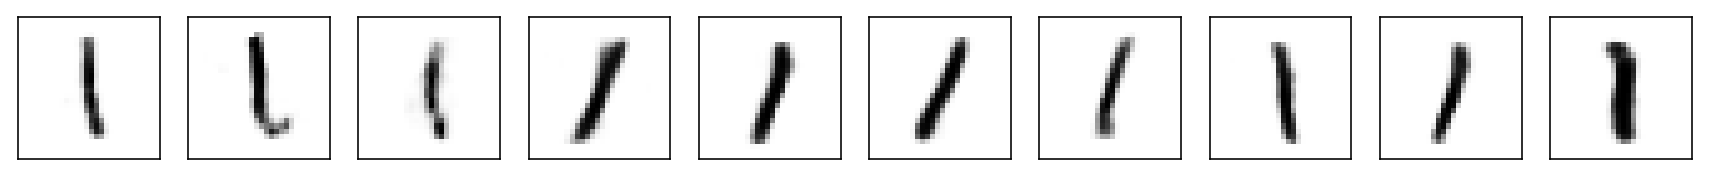

In [129]:
f, axarr = plt.subplots(1, 10,figsize=(15,15))

make_digit = 1

for i in range(10):
    
    noise = test.sample()
    
    ohc = [0]*10
    ohc[make_digit] = 1
    
    ohc = Variable(torch.Tensor(ohc)).cuda()
    
    a,b = test.decode(torch.cat([noise,ohc],dim=0))

    im_t = a

    im_t = im_t.data.cpu().numpy()

    axarr[i].imshow(np.reshape(im_t,(28,28)),cmap='gray_r')
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
    
plt.show()

# Visualise Latent Space: 2D Manifold

In [3]:
vae_n = VAE_NN.VAE_Net(latent_size=2,data='MNIST',conditional=True)

Train in IWAE mode (faster)

In [47]:
vae_n.load_state_dict(torch.load('../ModelWeights/MNIST_2D_100e_C'))

In [52]:
vae_n.cuda()

VAE_Net(
  (ei): Linear(in_features=794, out_features=500)
  (em): Linear(in_features=500, out_features=2)
  (ev): Linear(in_features=500, out_features=2)
  (di): Linear(in_features=12, out_features=500)
  (dom): Linear(in_features=500, out_features=784)
)

In [43]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

grid = np.linspace(0+1e-4, 1-1e-4, 20)

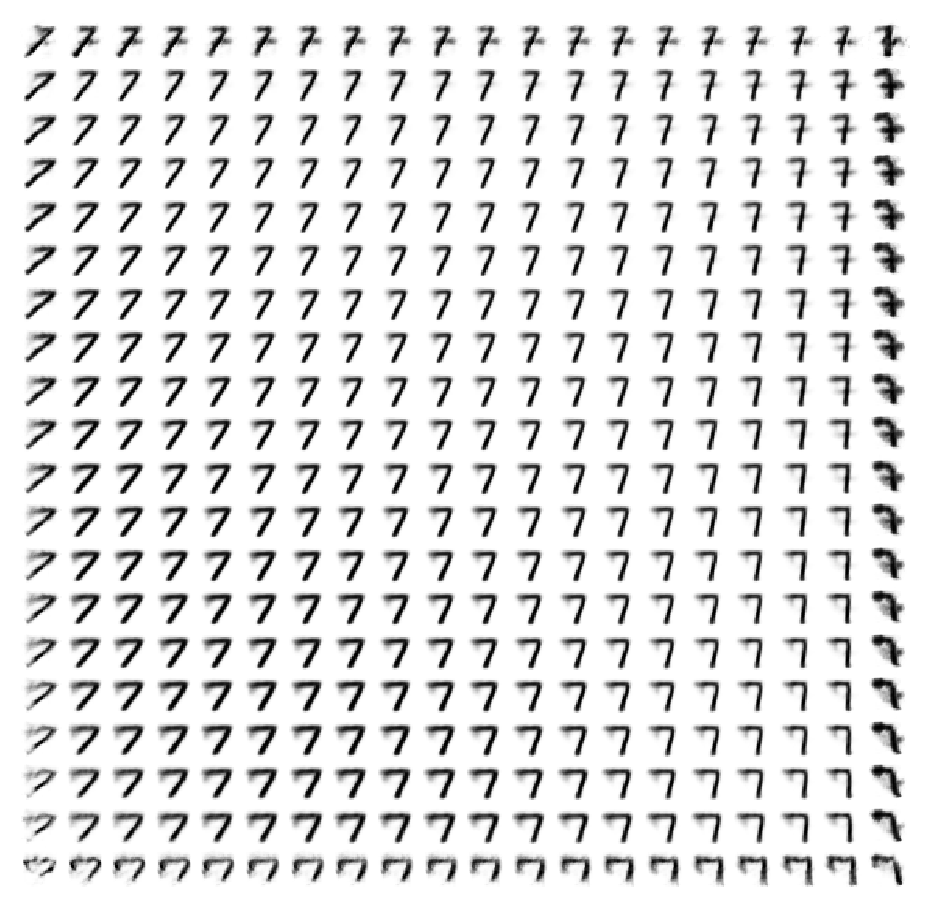

In [61]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(20, 20)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 

latent_number = 7

ohc = [0]*10
ohc[latent_number] = 1

ohc = Variable(torch.Tensor(ohc)).cuda()

for i in range(20):
    for j in range(20):
        ax1 = plt.subplot(gs1[i,j])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        noise = Variable(torch.Tensor([norm.ppf(grid[i]),norm.ppf(grid[j])])).cuda()
        im,_ = vae_n.decode(torch.cat([noise.view(1,2),ohc.view(1,10)],dim=1))
        im = im.data.cpu().numpy()
        plt.imshow(np.reshape(im,(28,28)),cmap='gray_r')
        plt.axis('off')
plt.savefig('./Images/MNIST_c_%d.png'%latent_number)
plt.show()

## LSD Plots

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_scatter_with_images(X_2d_data, images, img_name = None, figsize=(20,20), image_zoom=1, labels = None):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    #cmap_list = ['Blues_r','Oranges_r','Greens_r','Reds_r','Purples_r','copper','PuRd_r','Greys_r','winter','cool']
    cmap_list = ['viridis','plasma','Wistia','summer','spring','copper','PuRd_r','autumn','winter','cool']
    for c, (xy, i) in enumerate(zip(X_2d_data, images)):
        x0, y0 = xy
        if labels:
            img = OffsetImage(i, zoom=image_zoom, cmap = cmap_list[labels[c]])
        else:
            img = OffsetImage(i, zoom=image_zoom, cmap = 'gray')
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    if img_name:
        plt.savefig('./Images/' + img_name)
    plt.show()

In [8]:
vae_n = VAE_NN.VAE_Net(latent_size=20,conditional=True)

In [9]:
vae_n.load_state_dict(torch.load('../ModelWeights/MNIST_20D_100e_C'))

In [10]:
vae_n.cuda()

VAE_Net(
  (ei): Linear(in_features=794, out_features=500)
  (em): Linear(in_features=500, out_features=20)
  (ev): Linear(in_features=500, out_features=20)
  (di): Linear(in_features=30, out_features=500)
  (dom): Linear(in_features=500, out_features=784)
)

In [11]:
from sklearn.manifold import TSNE

In [12]:
tsne = TSNE(n_components=2, perplexity=40.0)

In [13]:
t_data,label = next(iter(train_data))

In [14]:
t_data = Variable(t_data).view(-1,784)

In [15]:
ohc = OneHotEncoder(sparse=False)
ohc.fit(np.arange(0,10).reshape(10,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [44]:
embeddings_20D = []
imgs = []
labels = []

for i, (t_data,label_v) in enumerate(train_data):
    if i >= 150:
        break
    for data,label in zip(Variable(t_data), Variable(label_v)):
        imgs.append(data.data.cpu().numpy().reshape(28,28))
        labels.append(label.data[0])
        data = data.view(1,784)
        label = Variable(torch.Tensor(ohc.transform(label.data[0]))).view(1,10)
        t_data = torch.cat([data,label],dim=1)
        m = vae_n.encode(t_data.cuda())[0]
        embedding = m.data.cpu().numpy()
        embeddings_20D.append(embedding)

In [46]:
embeddings_array = np.reshape(np.array(embeddings_20D),(-1,20))

In [47]:
tSNE_decomp = tsne.fit_transform(embeddings_array)

In [48]:
import matplotlib.colors

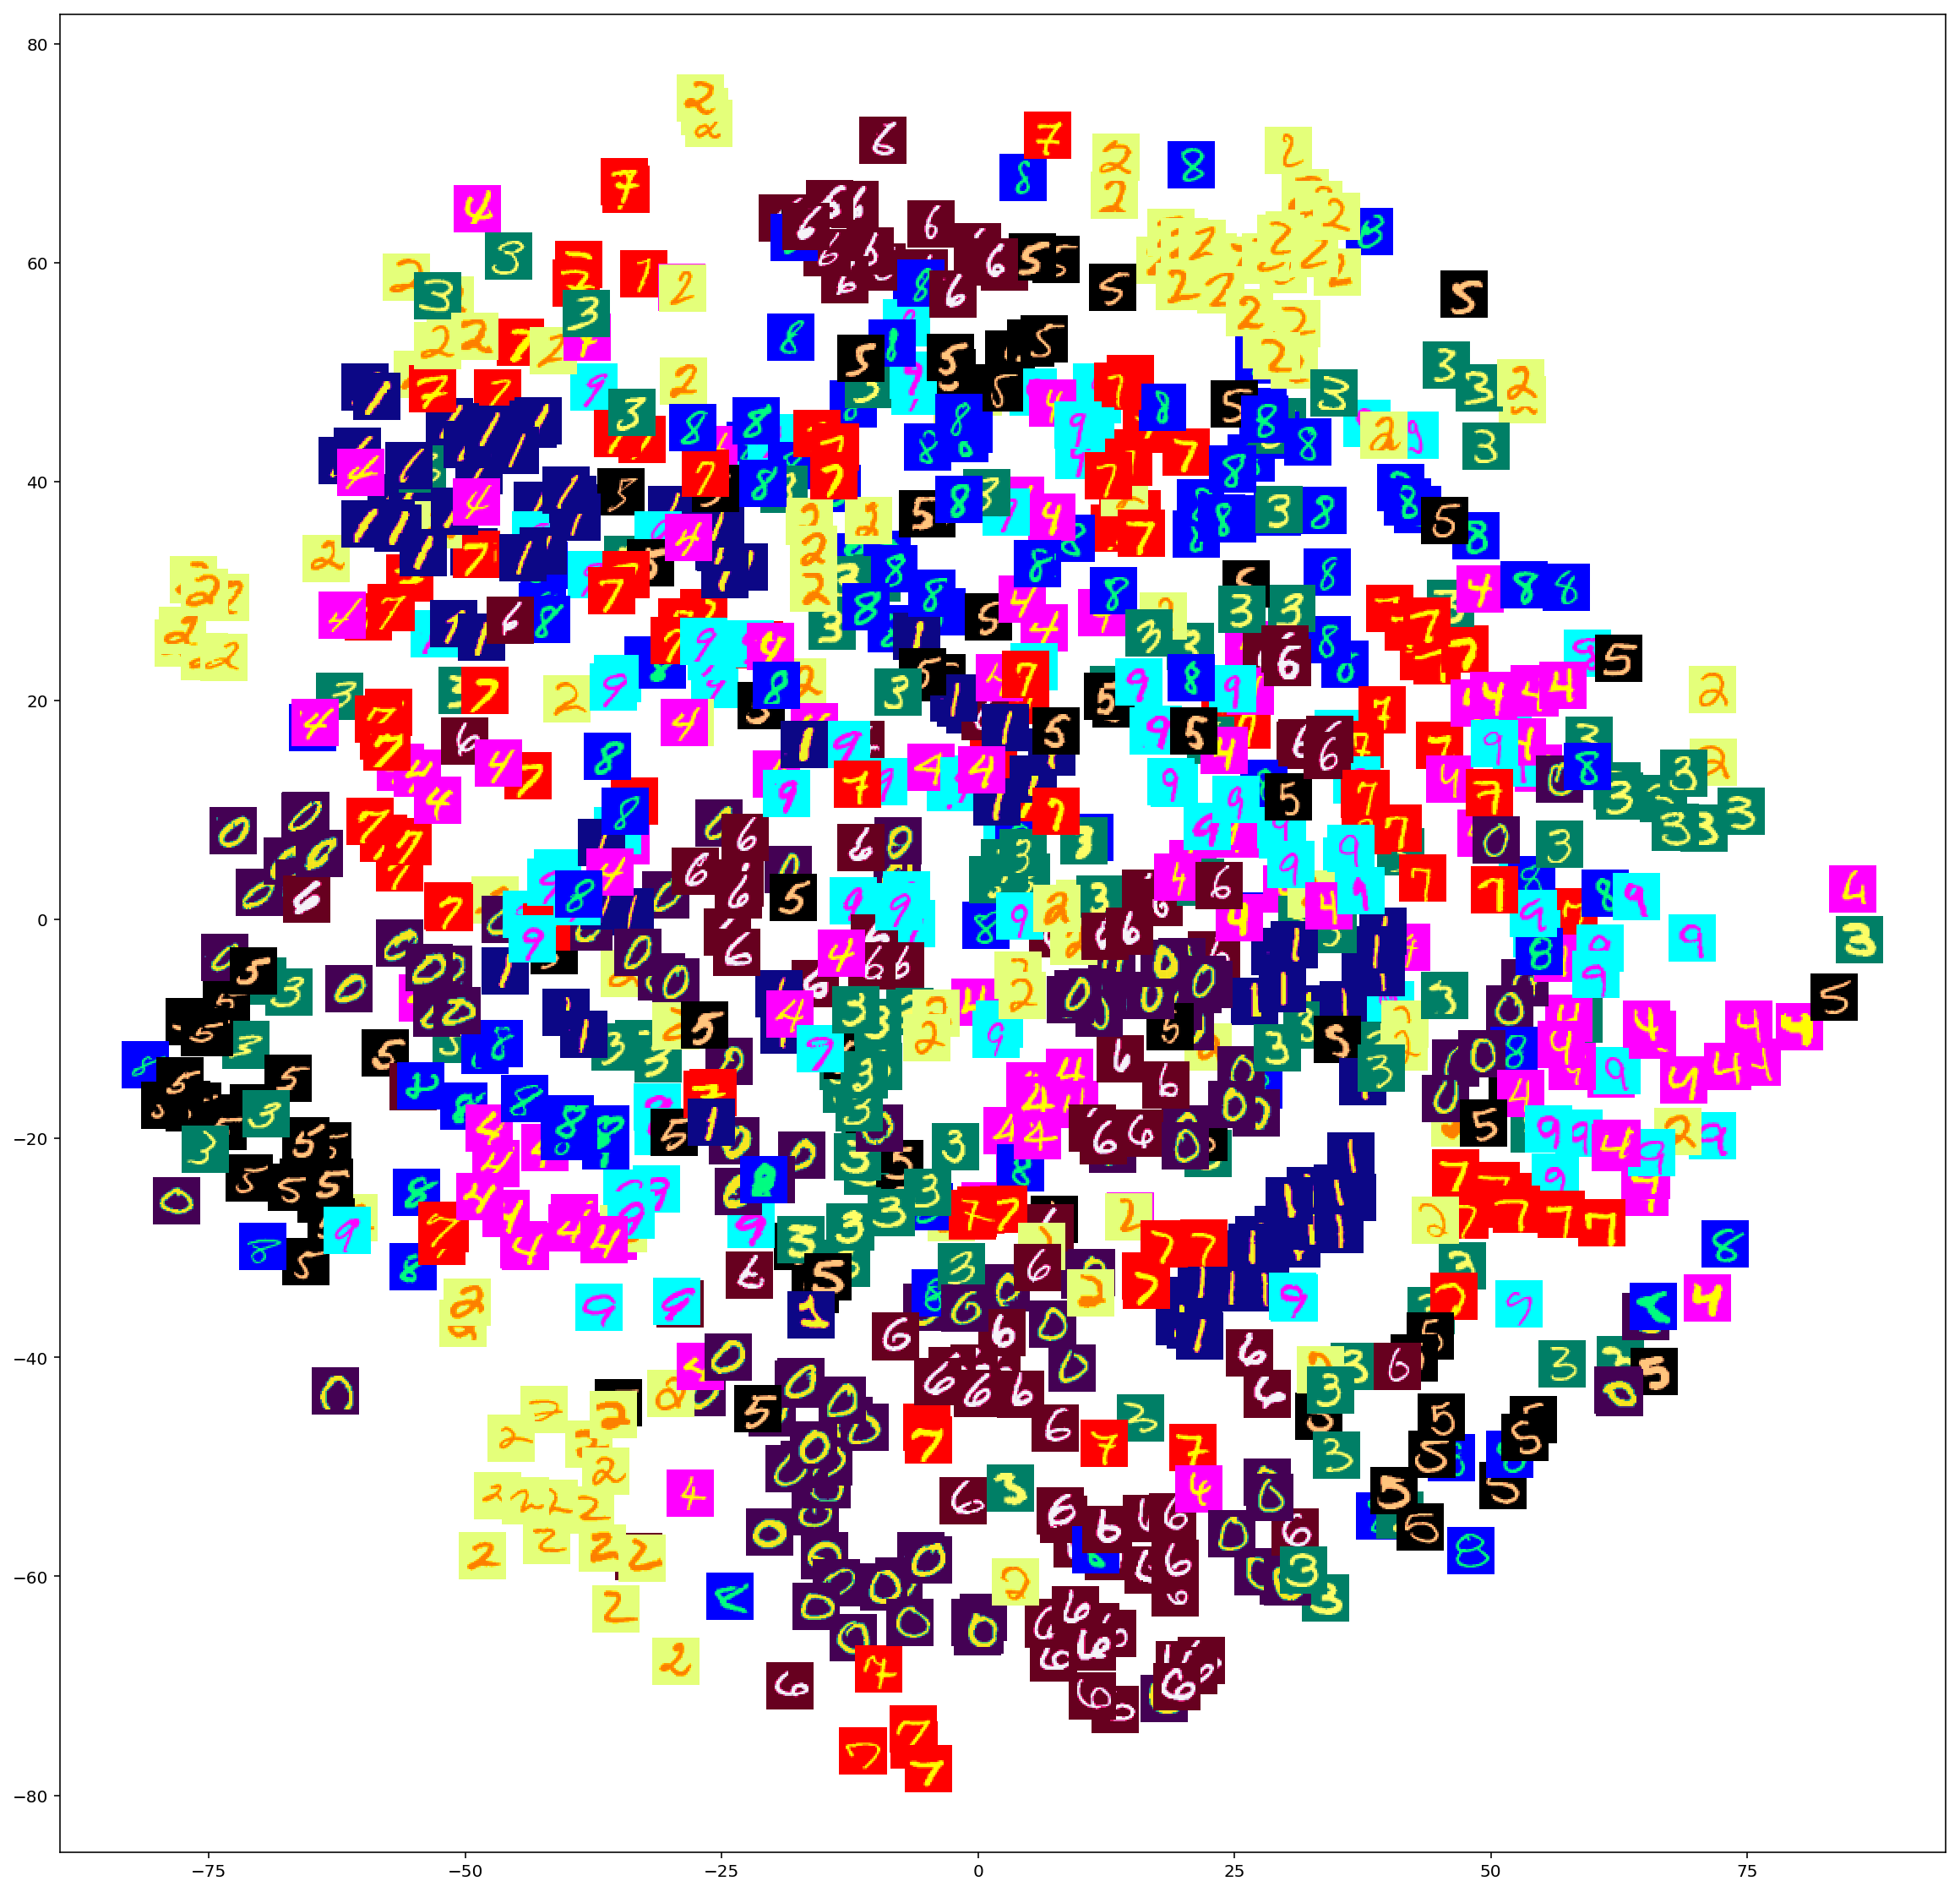

In [49]:
visualize_scatter_with_images(tSNE_decomp[:1000,:], imgs, labels = labels,img_name='20D_SNE_CVAE.eps')

Now select a certain label:

In [52]:
tSNE_decomp[:10]

array([[-52.979958 ,  26.065845 ],
       [ 58.10886  ,   0.7030845],
       [ -5.9737806,  57.665905 ],
       [-10.803967 , -22.971626 ],
       [ 19.139128 ,  12.451637 ],
       [ 26.211441 , -30.548431 ],
       [ -1.4455968,  12.82816  ],
       [-12.599684 , -45.754807 ],
       [ 13.239833 ,  21.000874 ],
       [-42.9628   ,  37.80914  ]], dtype=float32)

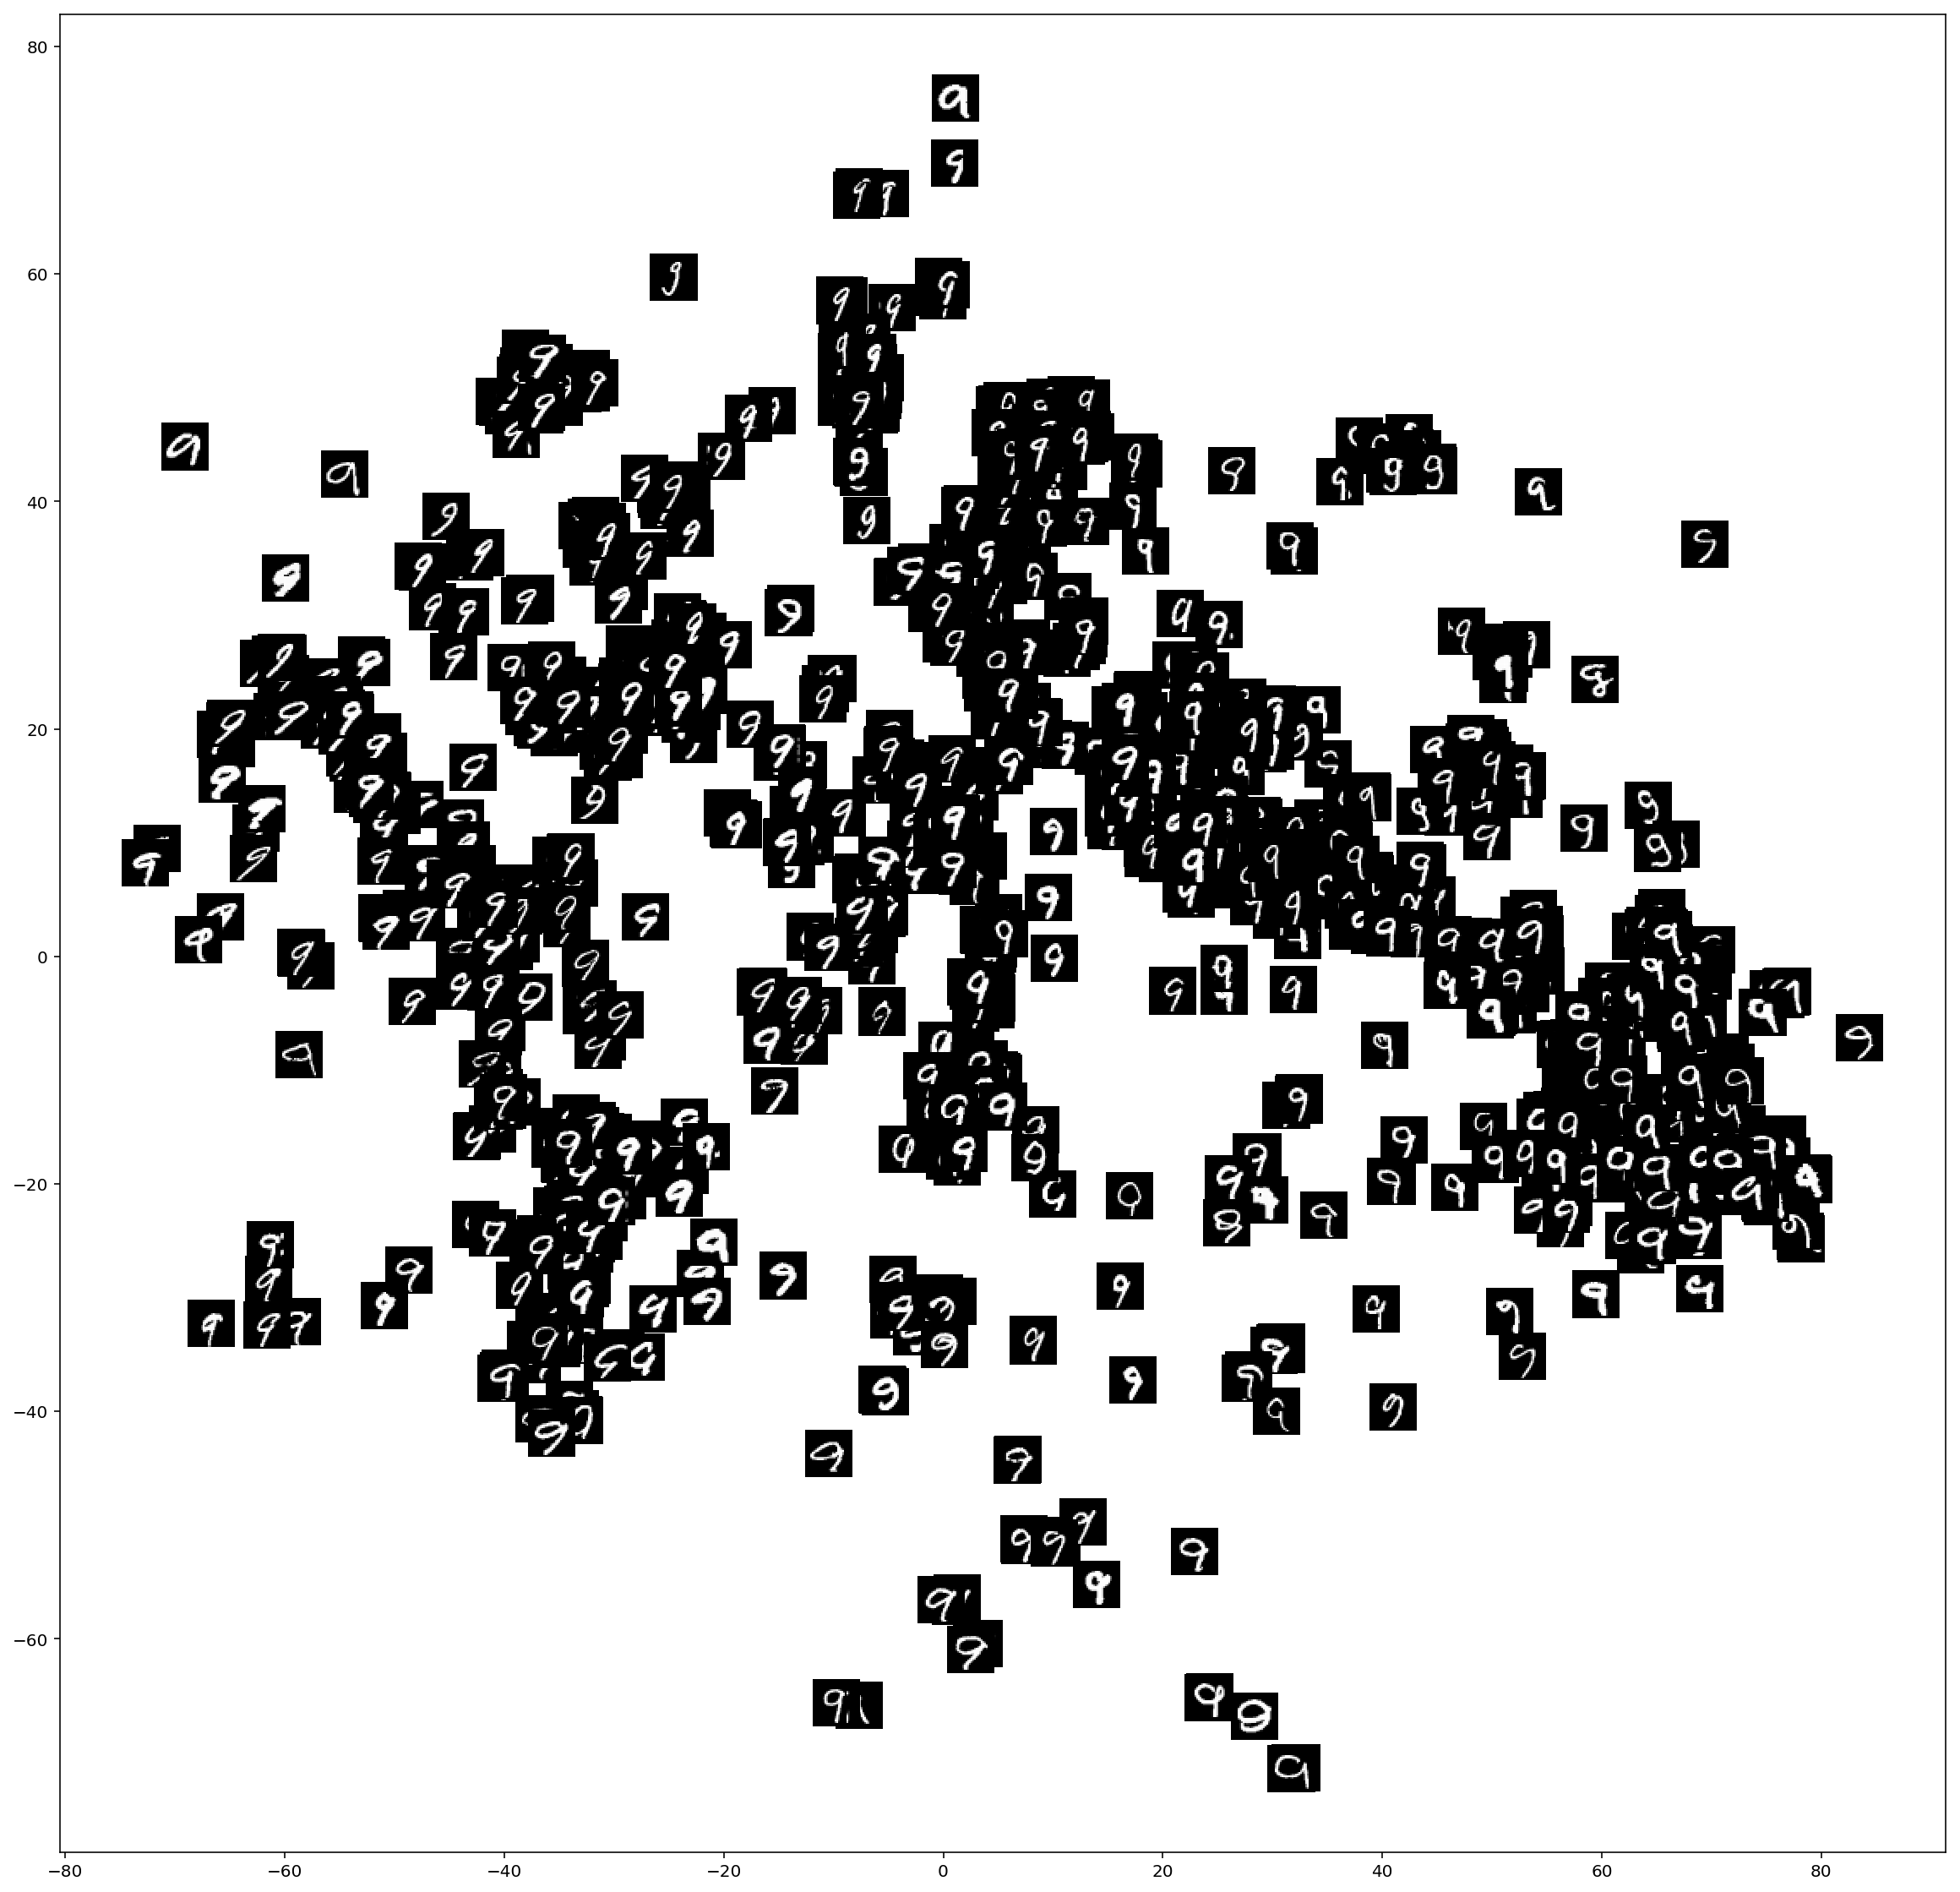

In [84]:
c_num = 9

subset_num_emb = []
subset_num_img = []

for lab,emb,img in zip(labels,tSNE_decomp,imgs):
    if lab == c_num:
        subset_num_emb.append(emb)
        subset_num_img.append(img)
        
subset_num_emb = np.array(subset_num_emb)

visualize_scatter_with_images(subset_num_emb, subset_num_img ,img_name='20D_SNE_CVAE_%d.eps'%c_num)

# LSD Plots with 2 Latent Variables

In [31]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_scatter_with_images(X_2d_data, images, img_name = None, figsize=(20,20), image_zoom=1, labels = None):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    #cmap_list = ['Blues_r','Oranges_r','Greens_r','Reds_r','Purples_r','copper','PuRd_r','Greys_r','winter','cool']
    cmap_list = ['viridis','plasma','Wistia','summer','spring','copper','PuRd_r','autumn','winter','cool']
    for c, (xy, i) in enumerate(zip(X_2d_data, images)):
        x0, y0 = xy
        if labels:
            img = OffsetImage(i, zoom=image_zoom, cmap = cmap_list[labels[c]])
        else:
            img = OffsetImage(i, zoom=image_zoom, cmap = 'gray')
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    #ax.set_xlim((-3,3))
    #ax.set_ylim((-3,3))
    if img_name:
        plt.savefig('./Images/' + img_name)
    plt.show()

In [50]:
vae_n = VAE_NN.VAE_Net(latent_size=2,conditional=True,data='MNIST')

In [51]:
vae_n.load_state_dict(torch.load('../ModelWeights/MNIST_2D_100e_C'))

In [54]:
vae_n.cuda()

VAE_Net(
  (ei): Linear(in_features=794, out_features=500)
  (em): Linear(in_features=500, out_features=2)
  (ev): Linear(in_features=500, out_features=2)
  (di): Linear(in_features=12, out_features=500)
  (dom): Linear(in_features=500, out_features=784)
)

In [55]:
ohc = OneHotEncoder(sparse=False)
ohc.fit(np.arange(0,10).reshape(10,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [56]:
embeddings_2D = []
imgs = []
labels = []

for i, (t_data,label_v) in enumerate(train_data):
    if i >= 150:
        break
    for data,label in zip(Variable(t_data), Variable(label_v)):
        imgs.append(data.data.cpu().numpy().reshape(28,28))
        labels.append(label.data[0])
        data = data.view(1,784)
        label = Variable(torch.Tensor(ohc.transform(label.data[0]))).view(1,10)
        t_data = torch.cat([data,label],dim=1)
        m = vae_n.encode(t_data.cuda())[0]
        embedding = m.data.cpu().numpy()
        embeddings_2D.append(embedding)

In [57]:
embeddings_array = np.reshape(np.array(embeddings_2D),(-1,2))

In [58]:
import matplotlib.colors

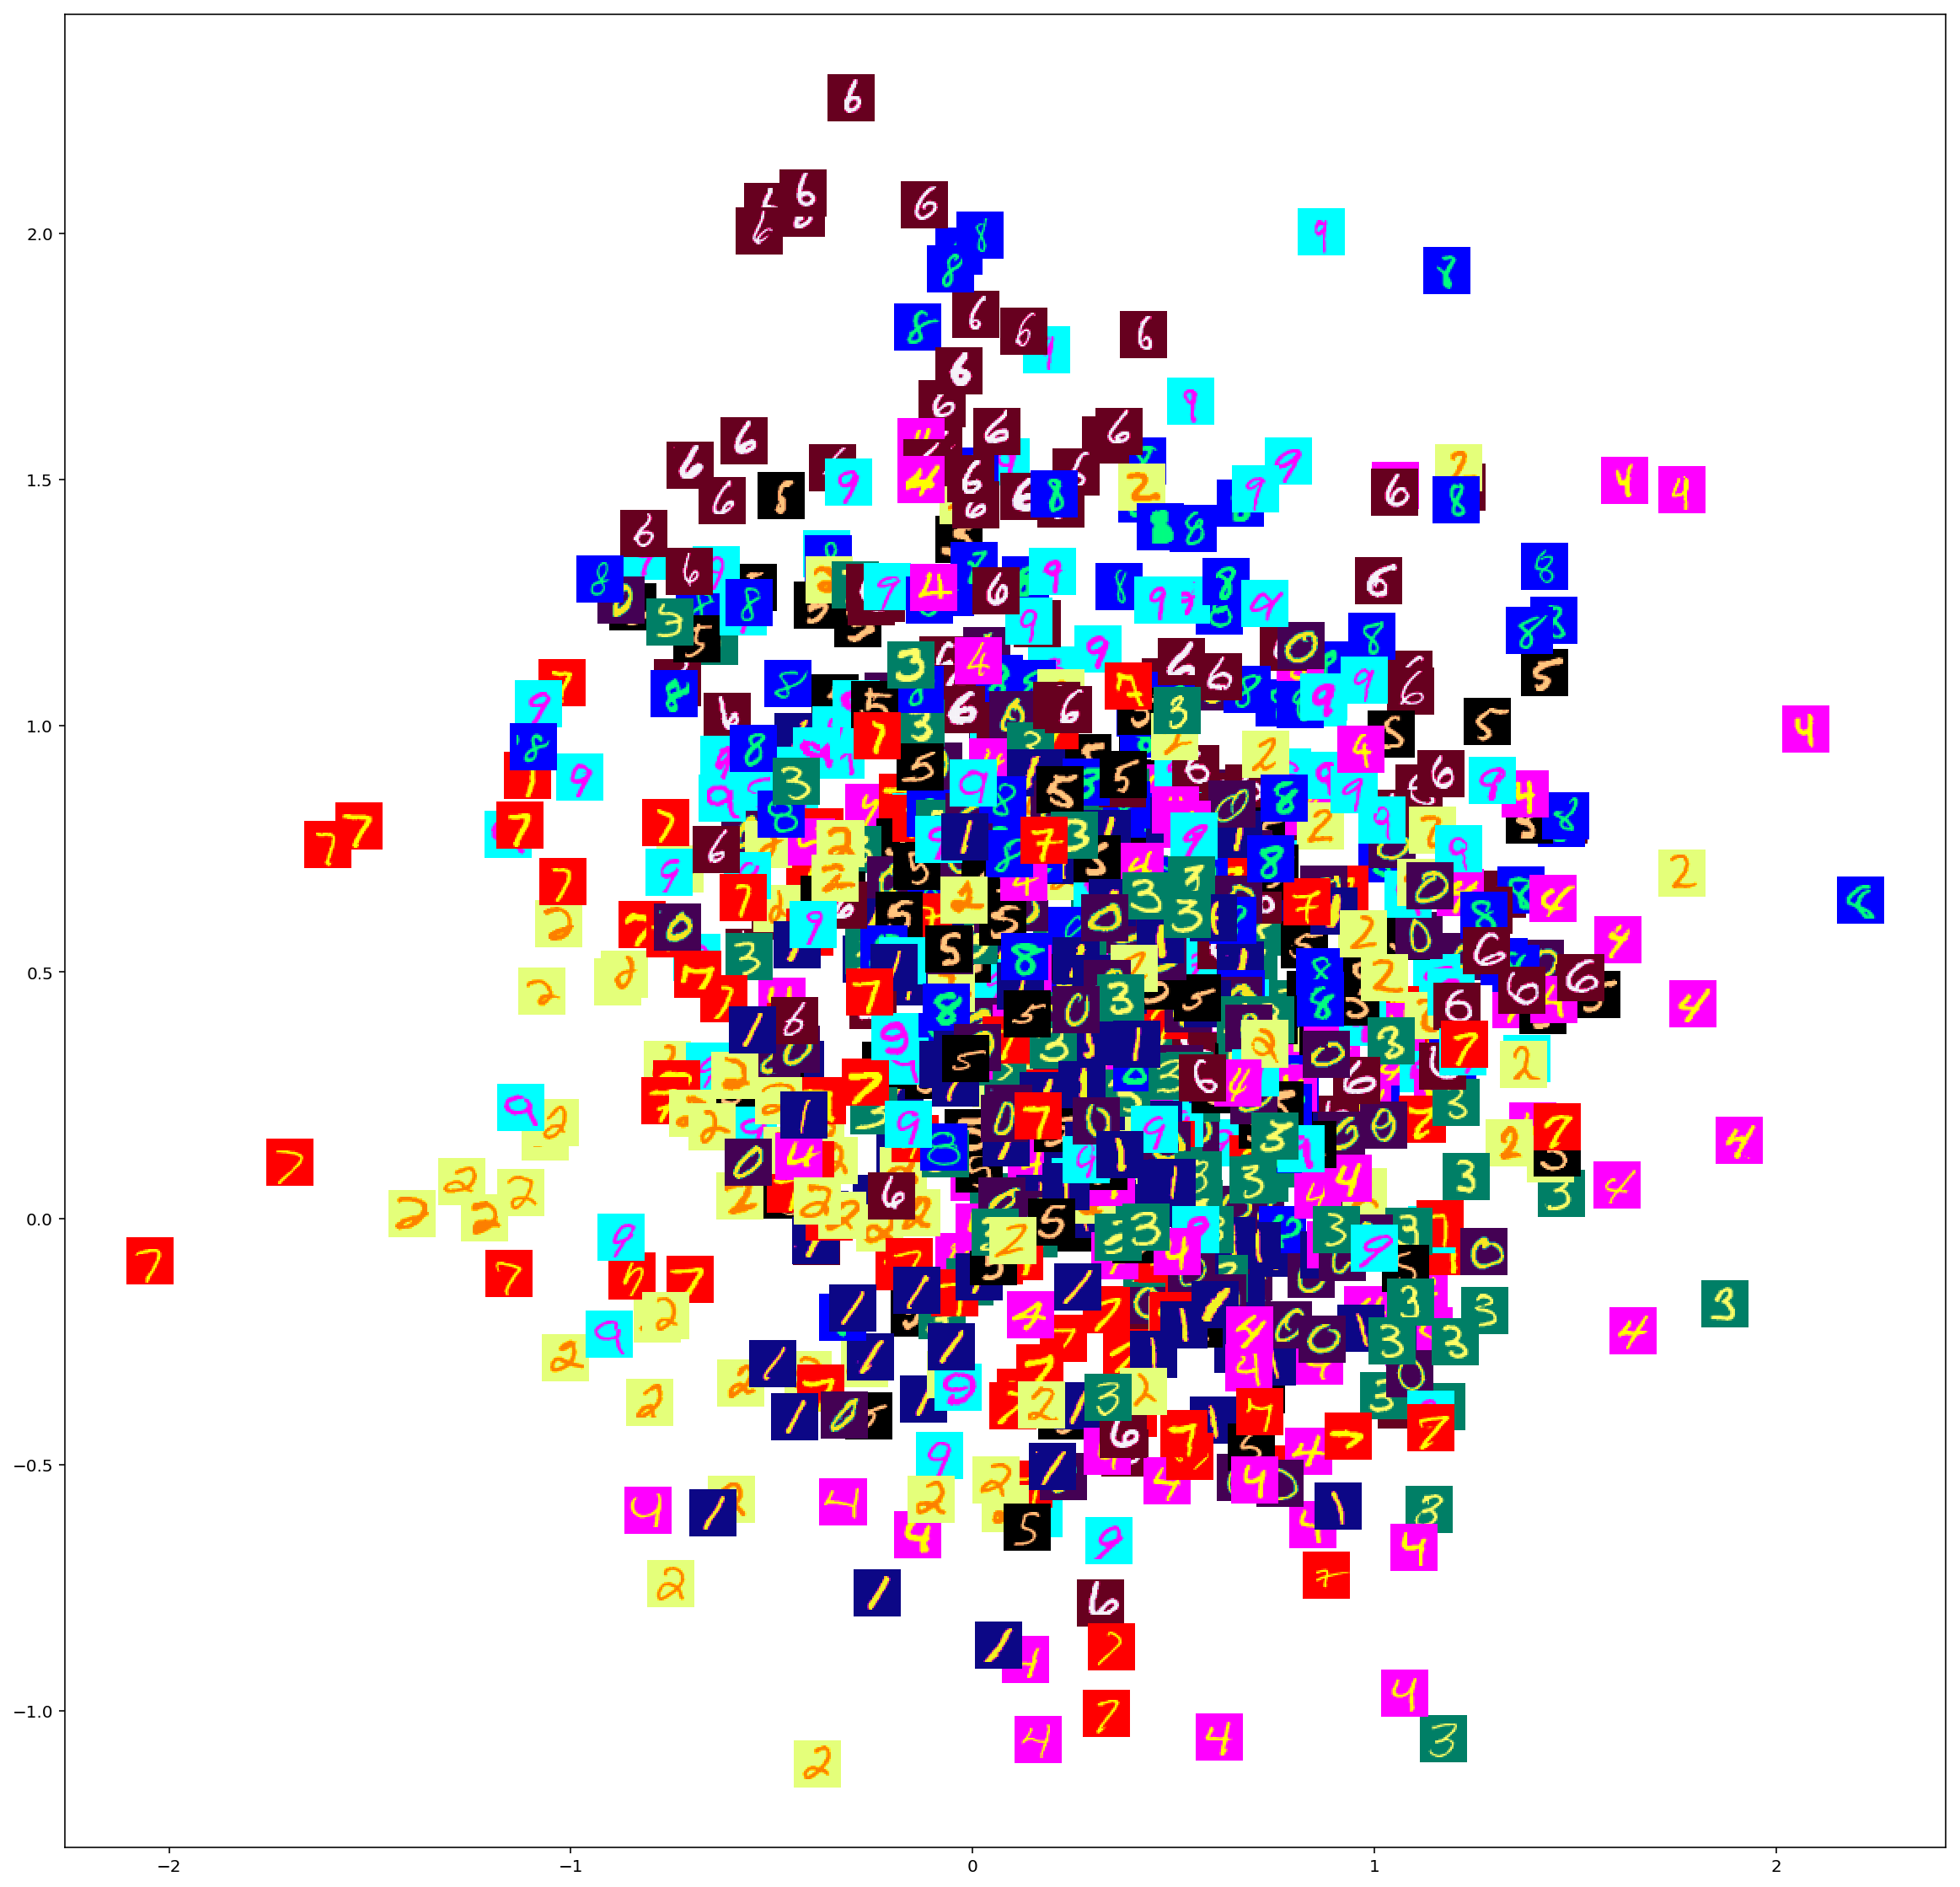

In [59]:
visualize_scatter_with_images(embeddings_array[:1000,:], imgs, labels = labels,img_name='2D_SNE_CVAE.eps')

Now select a certain label:

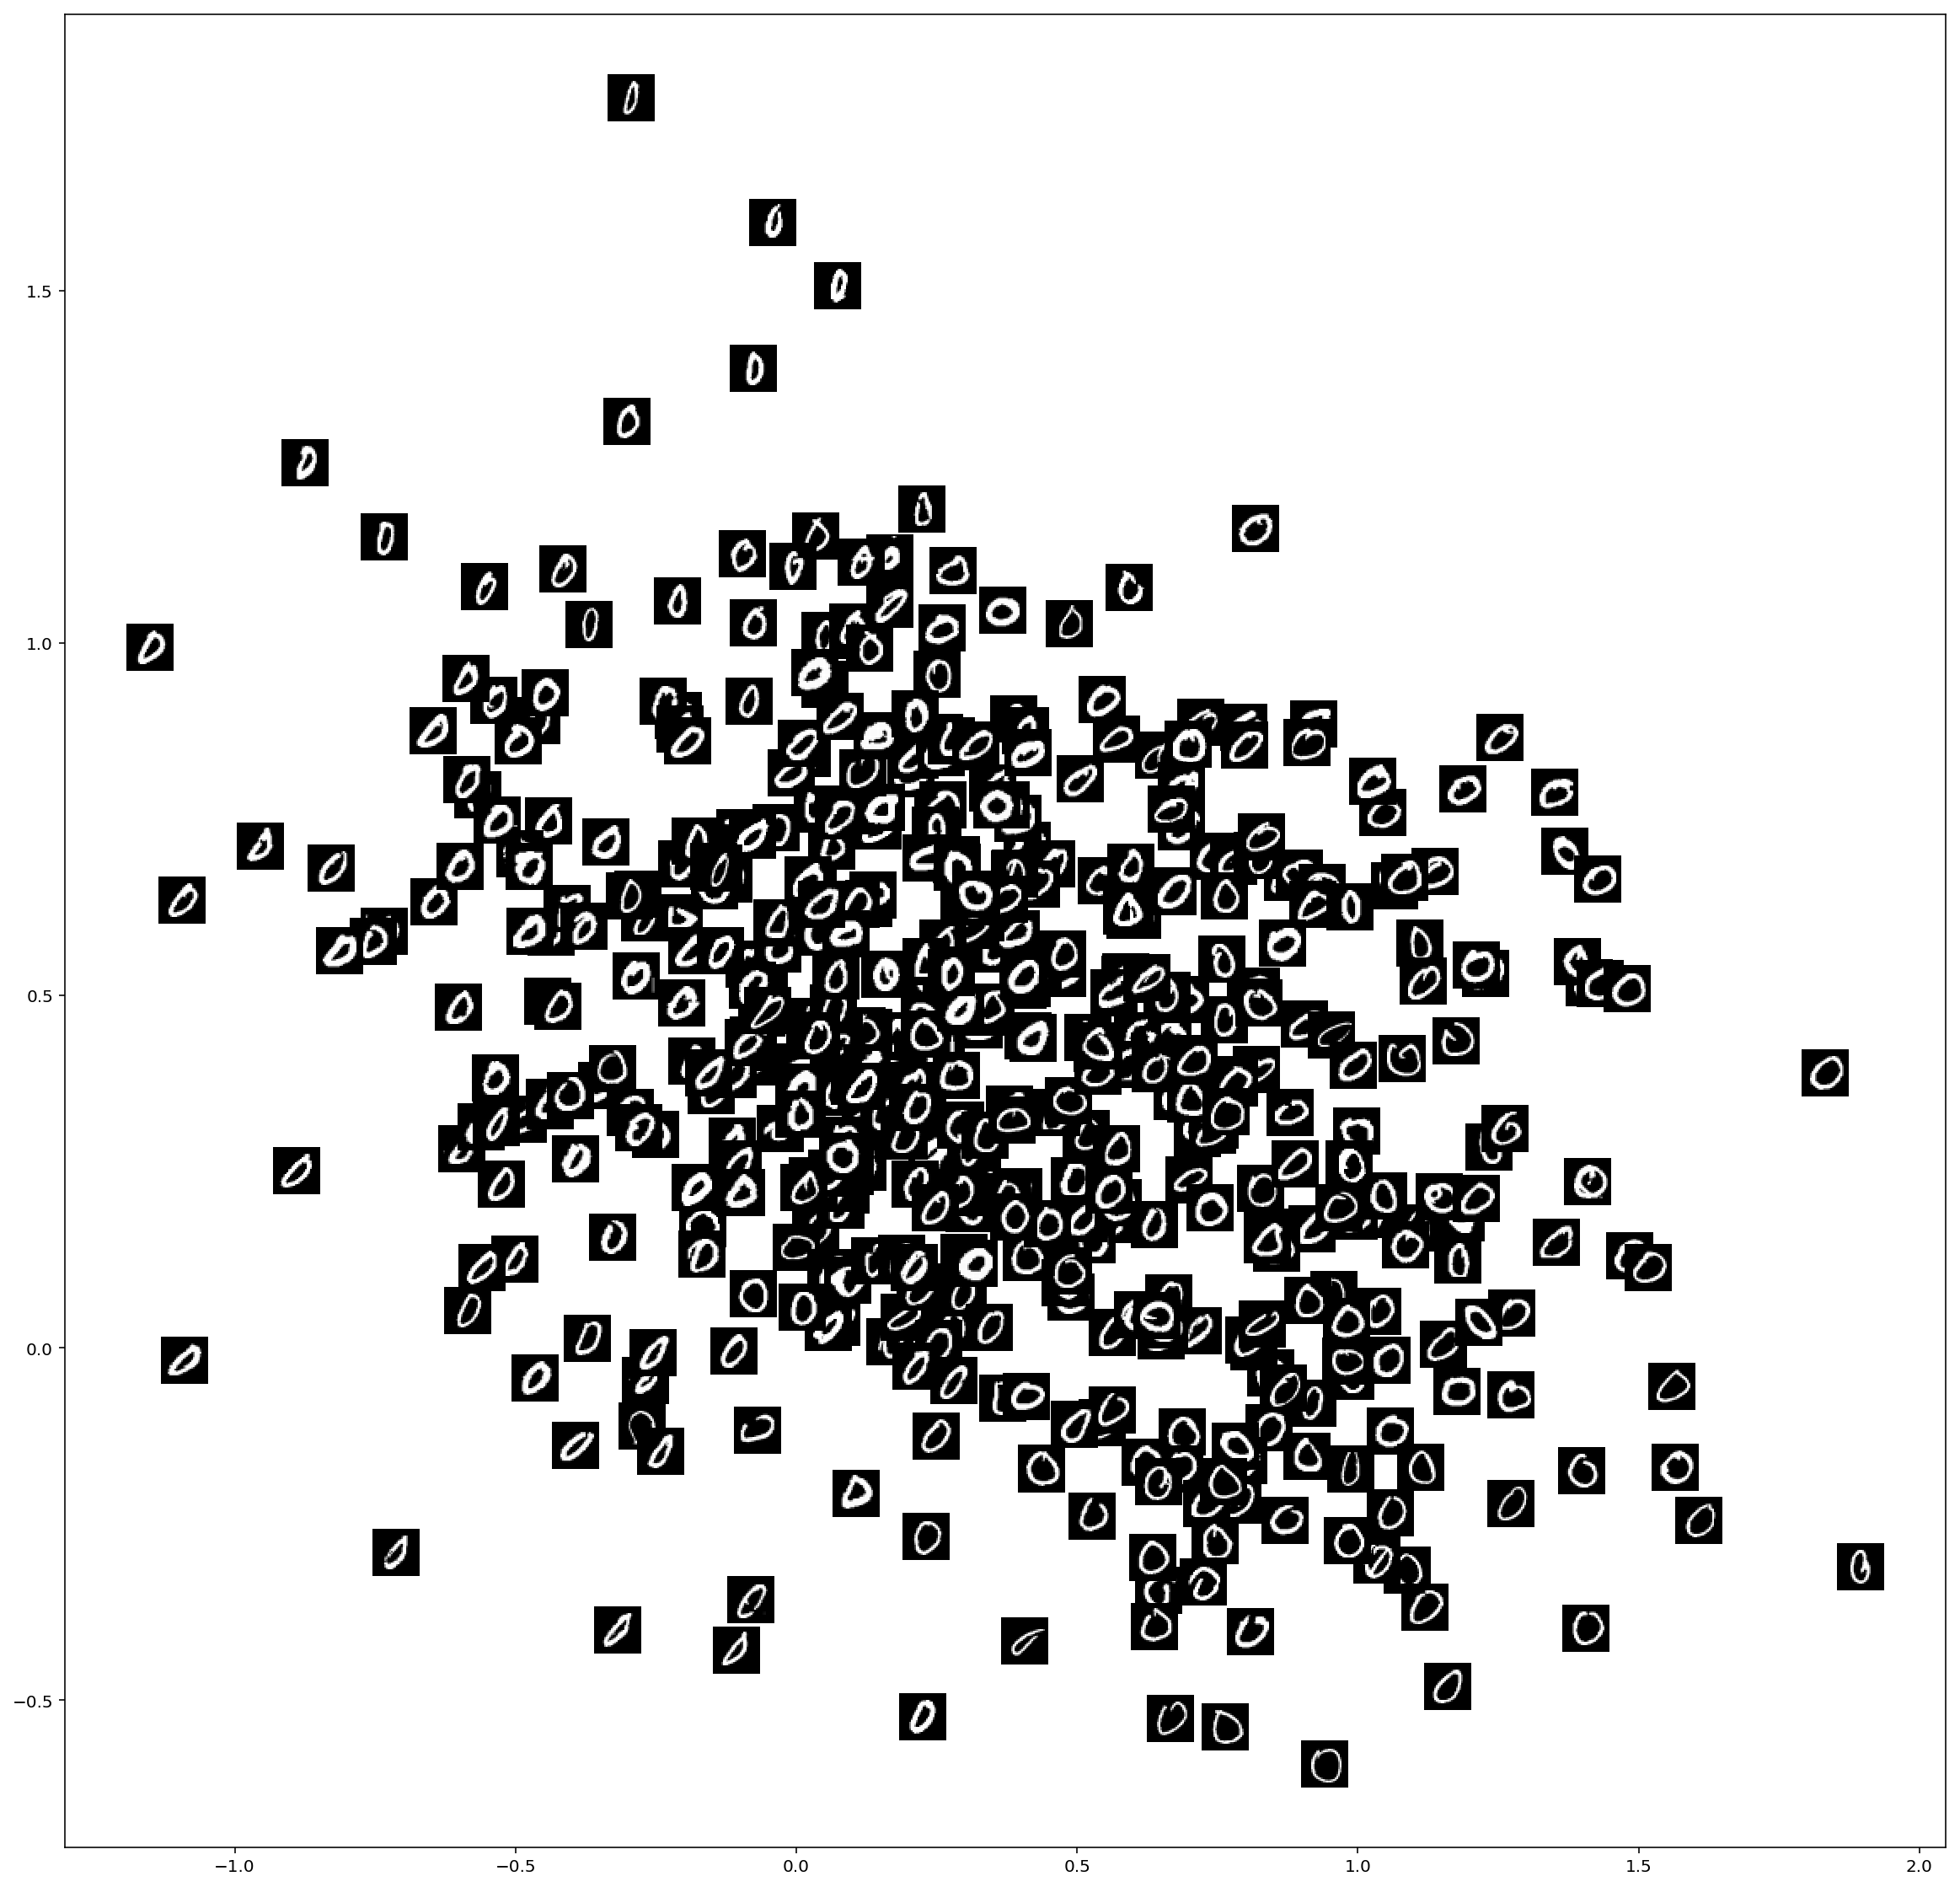

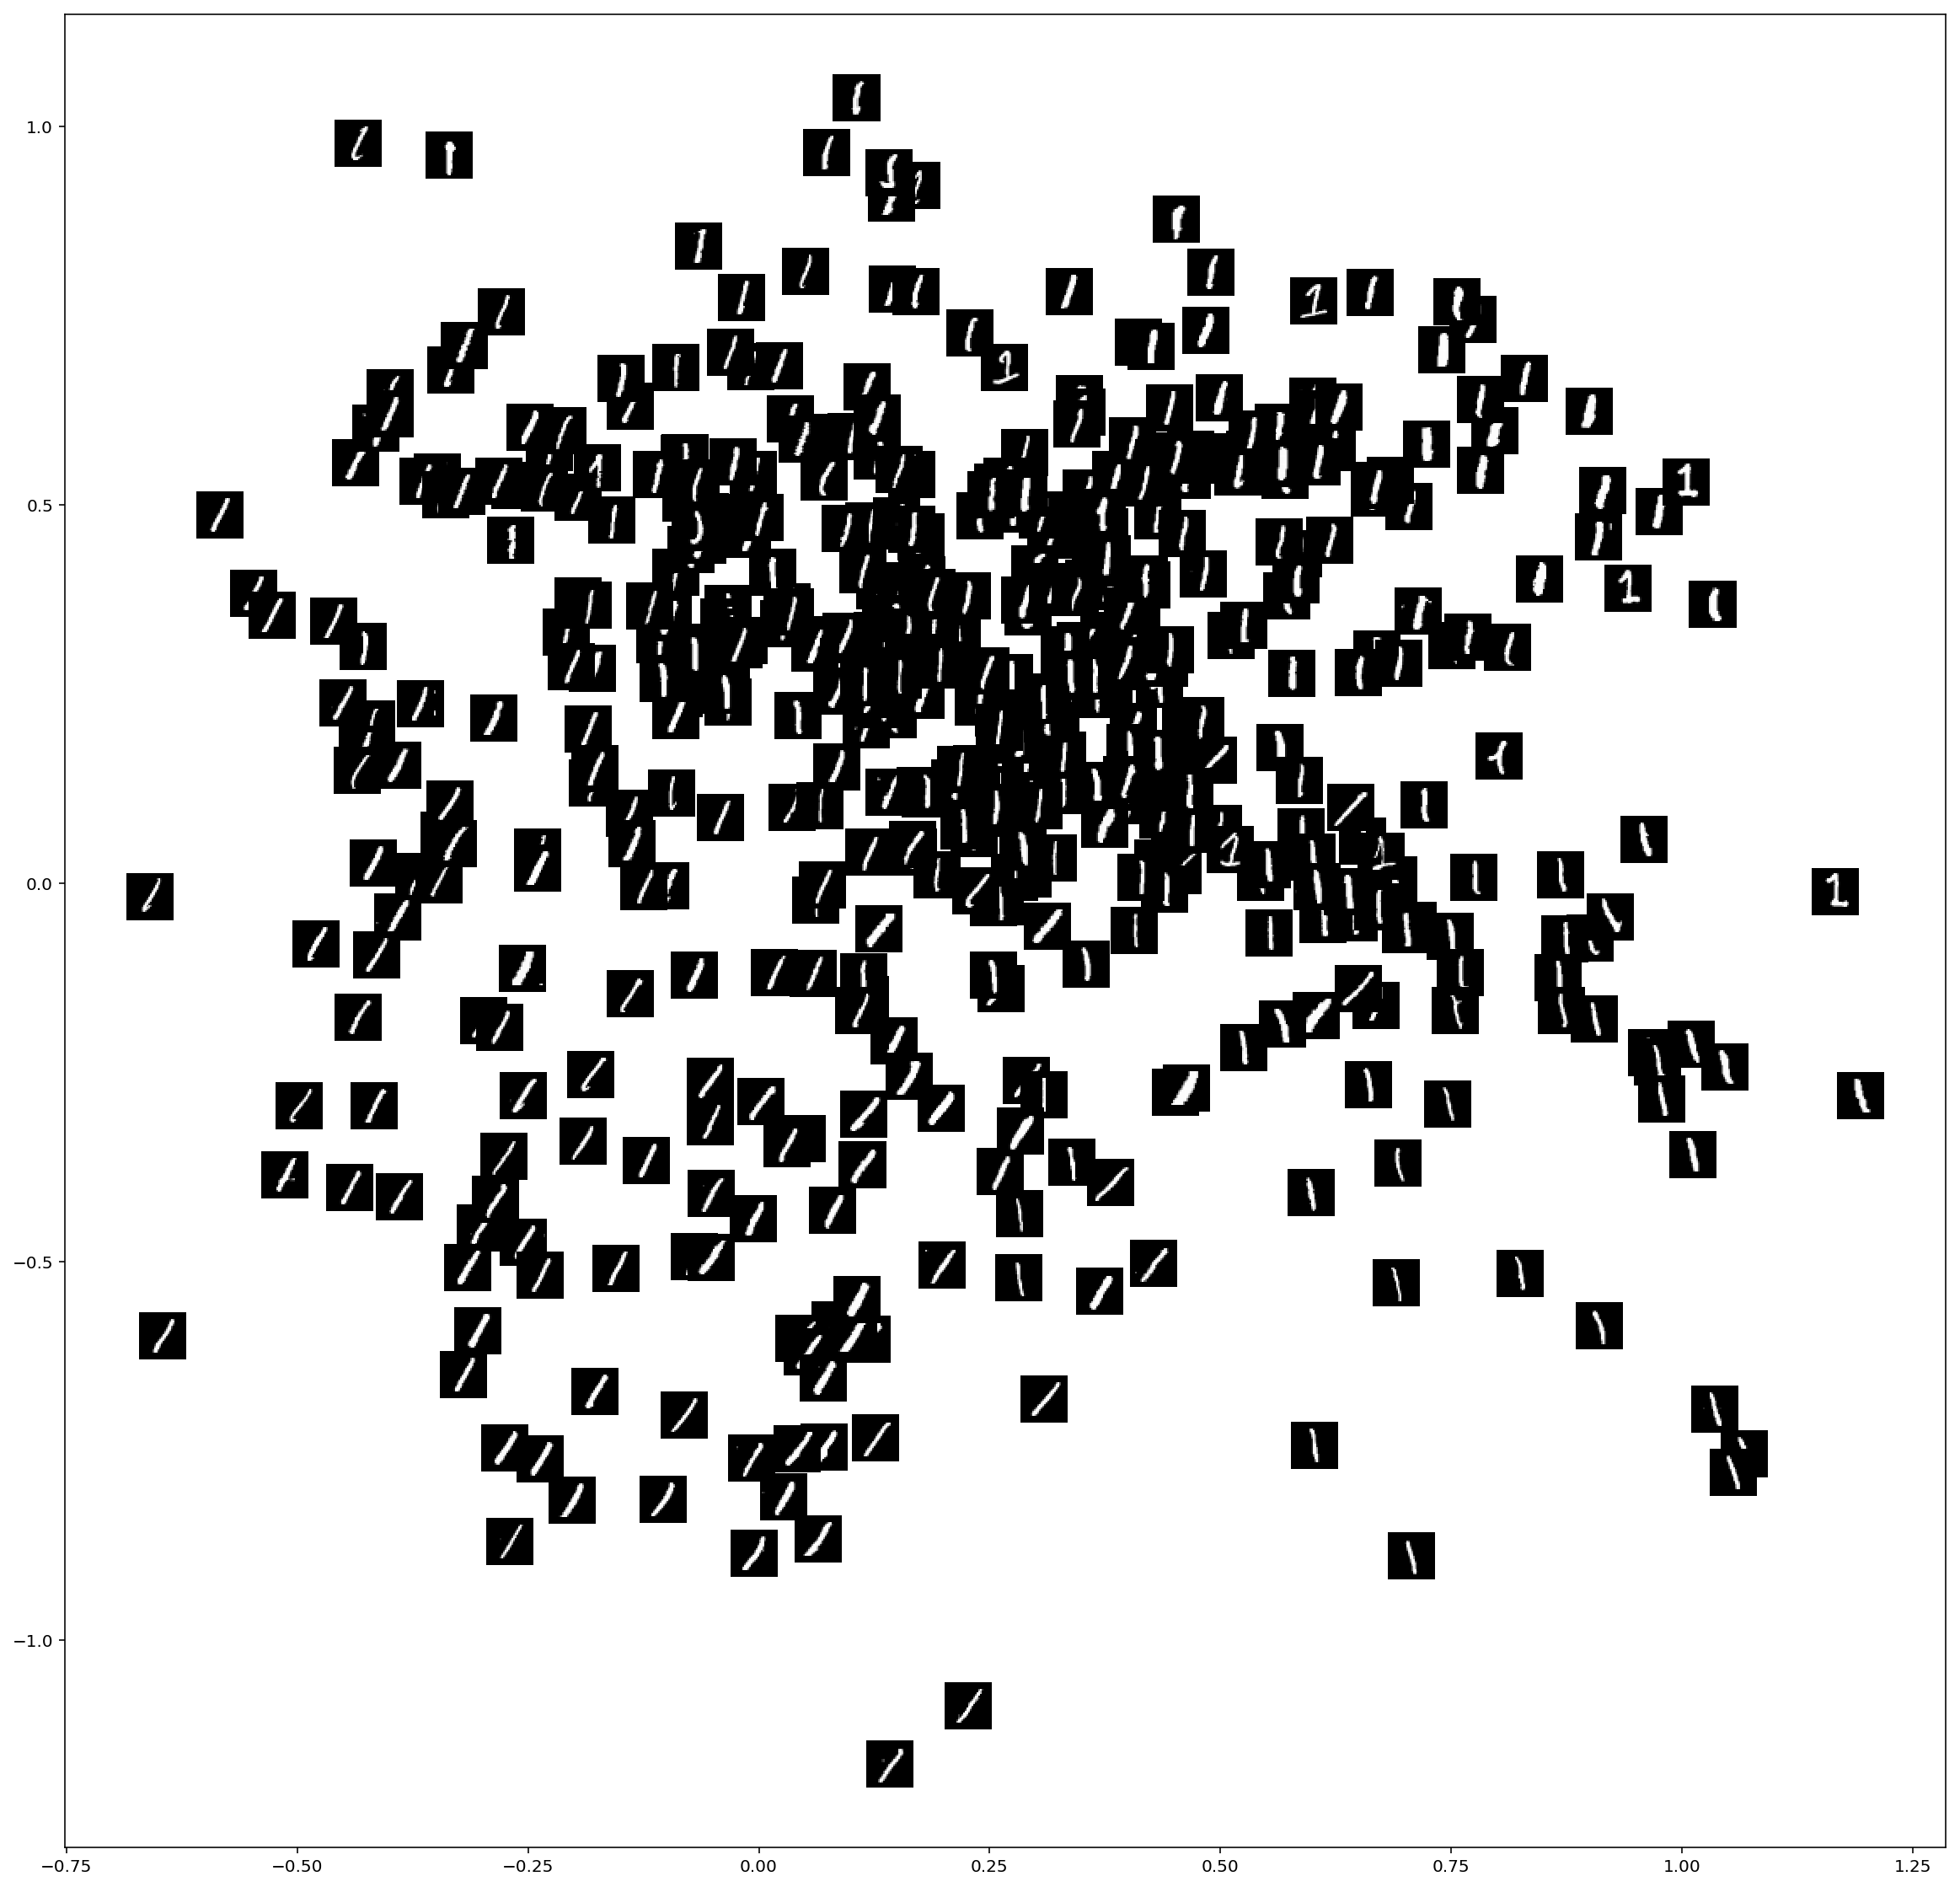

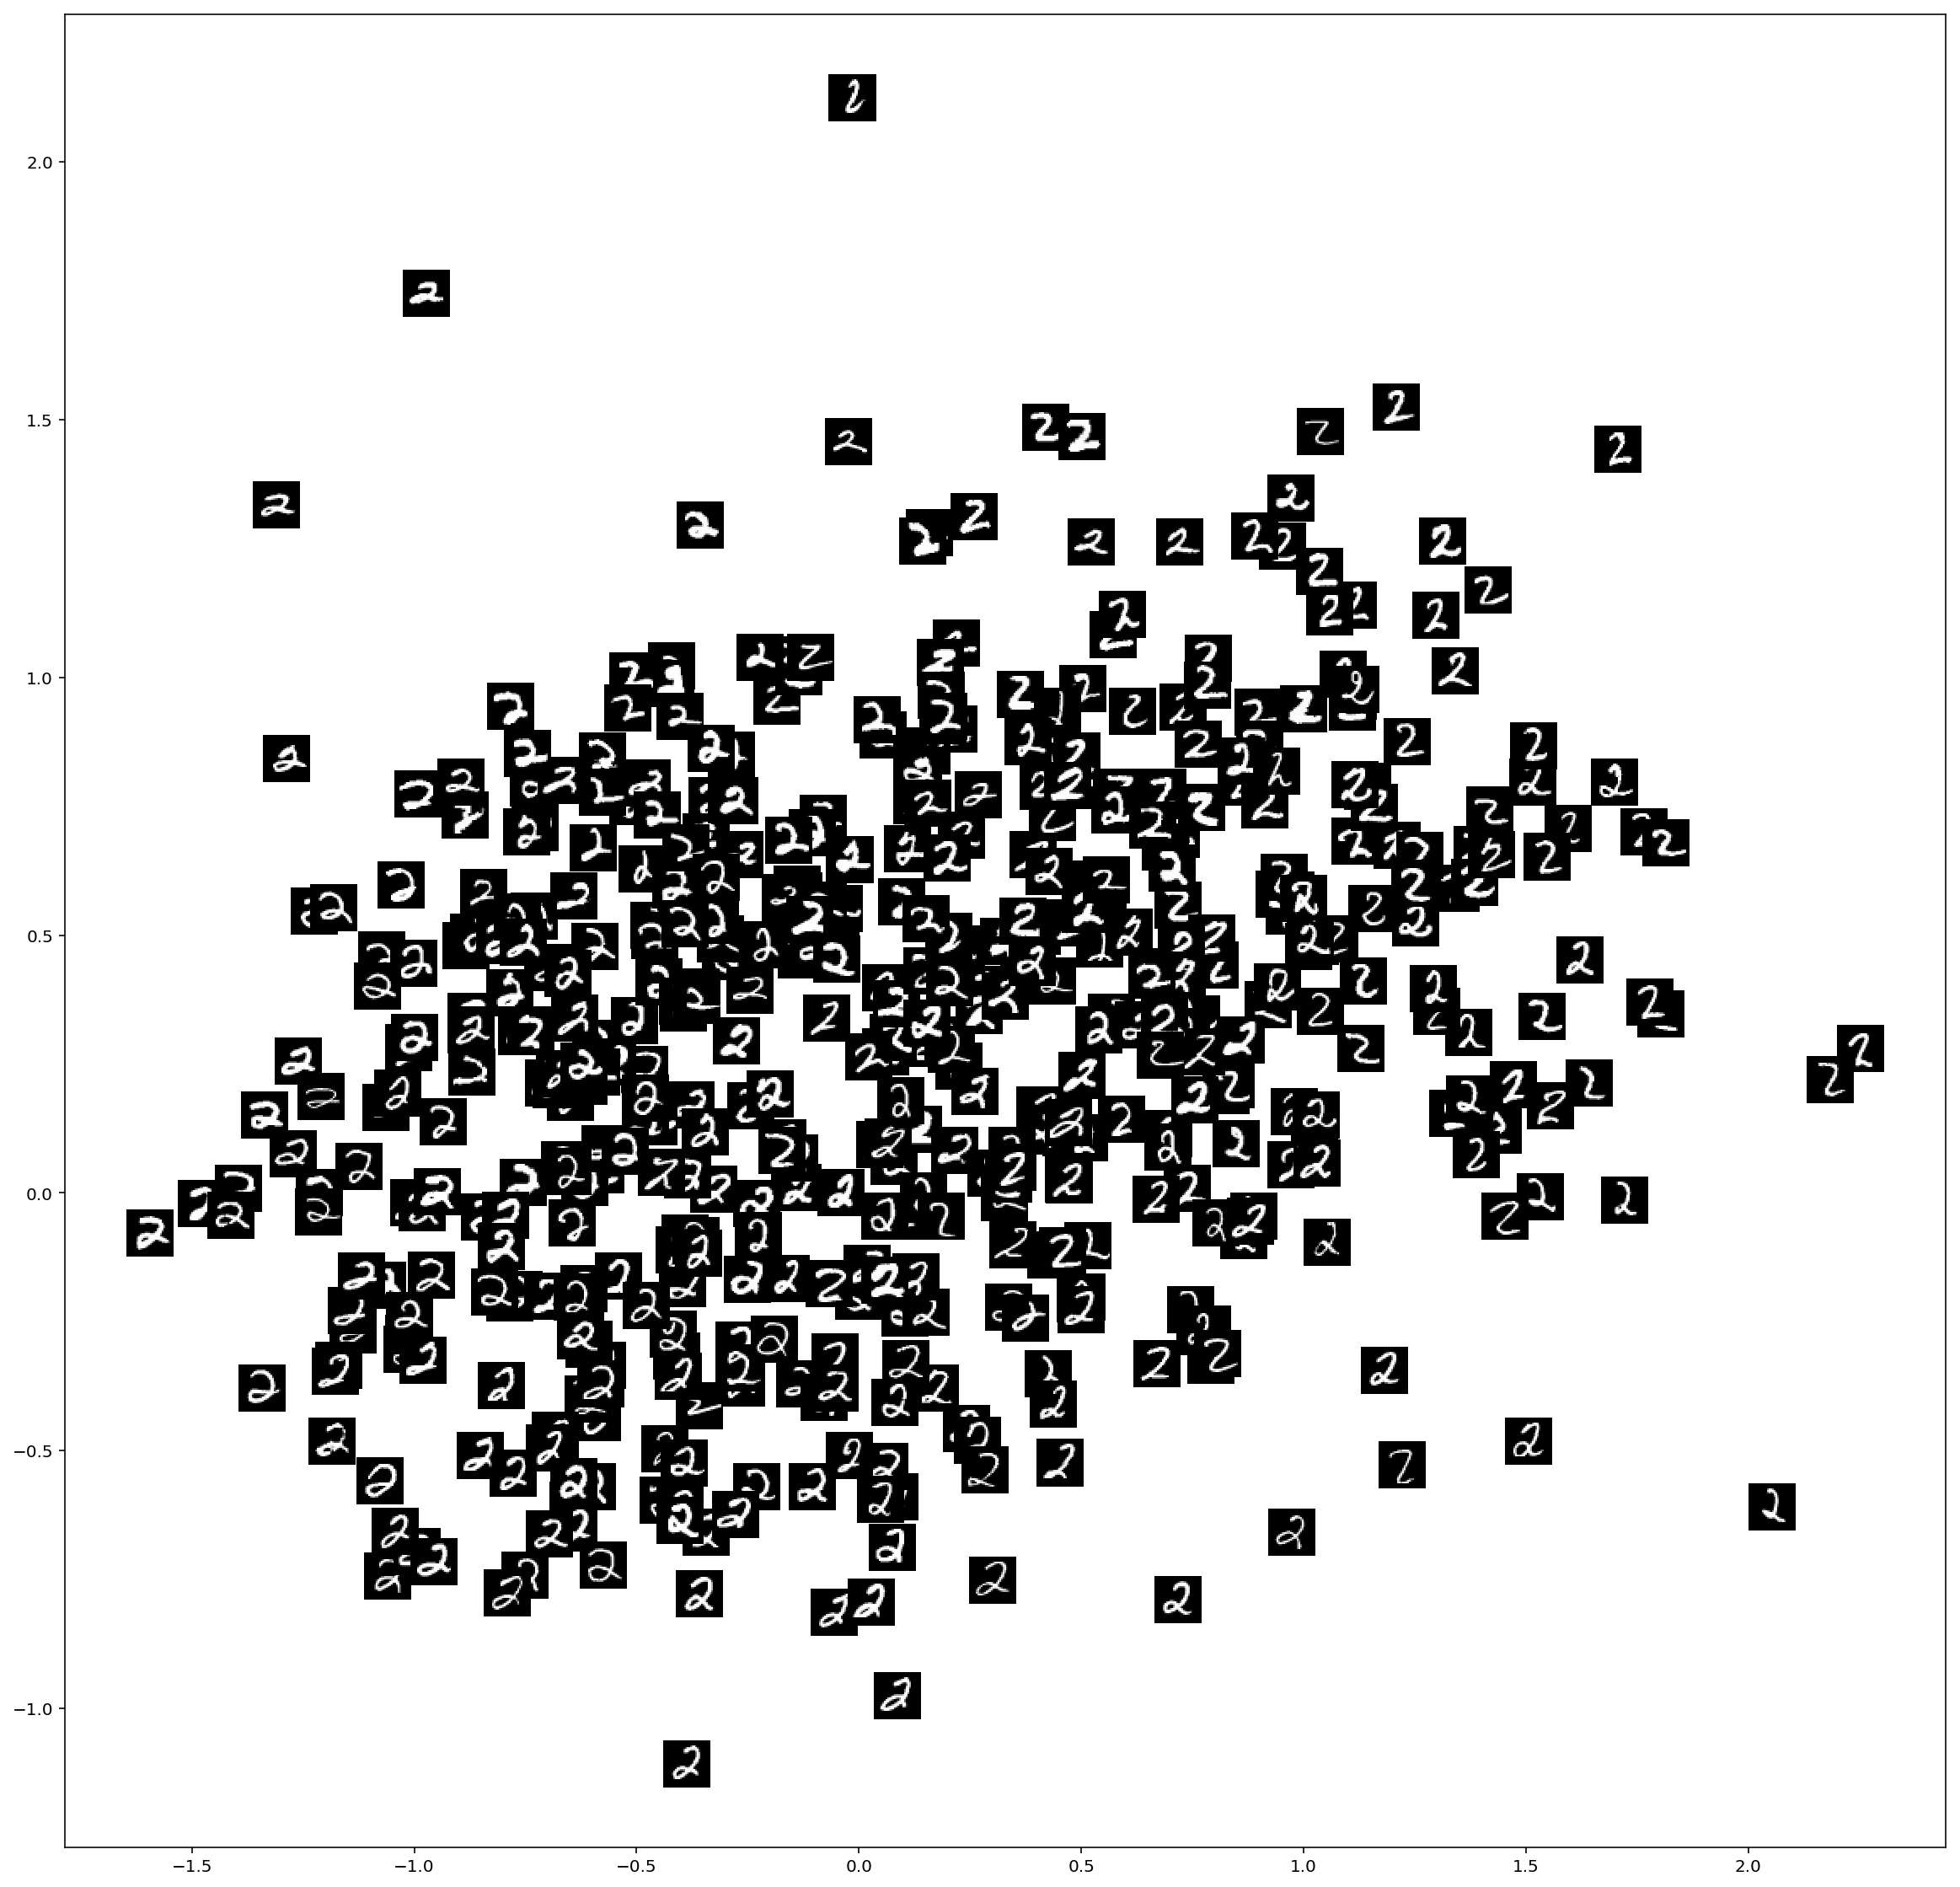

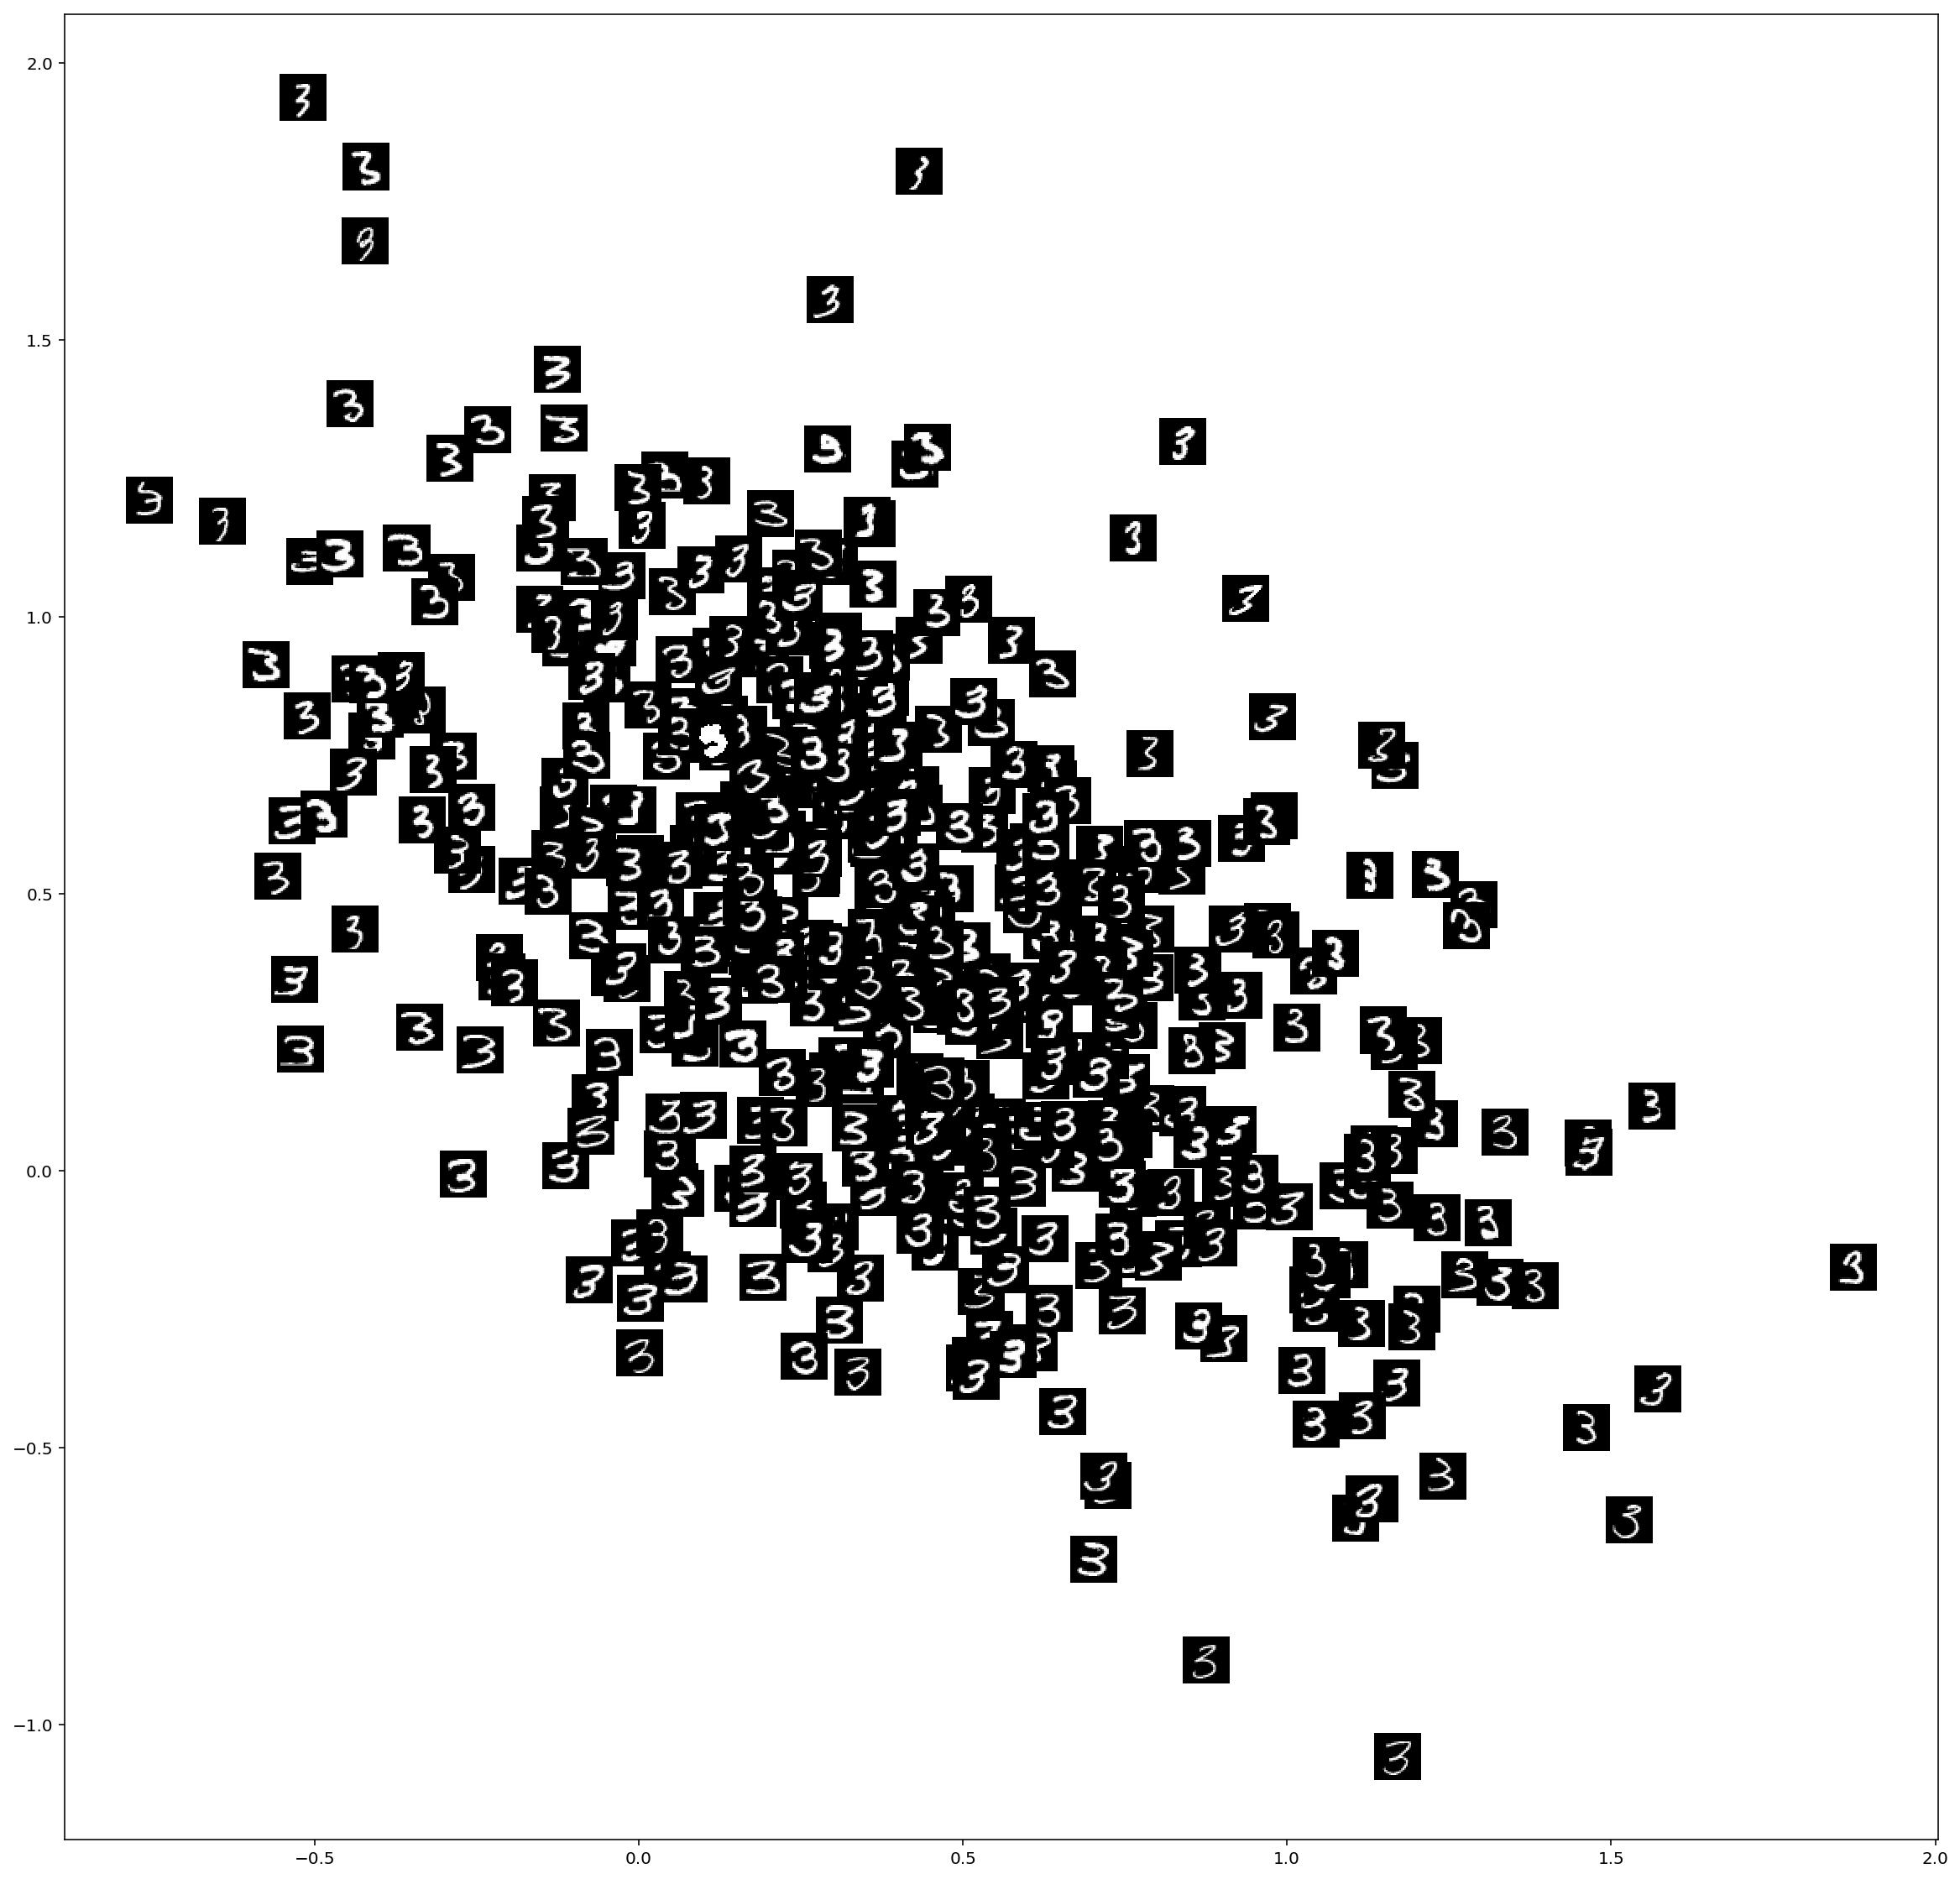

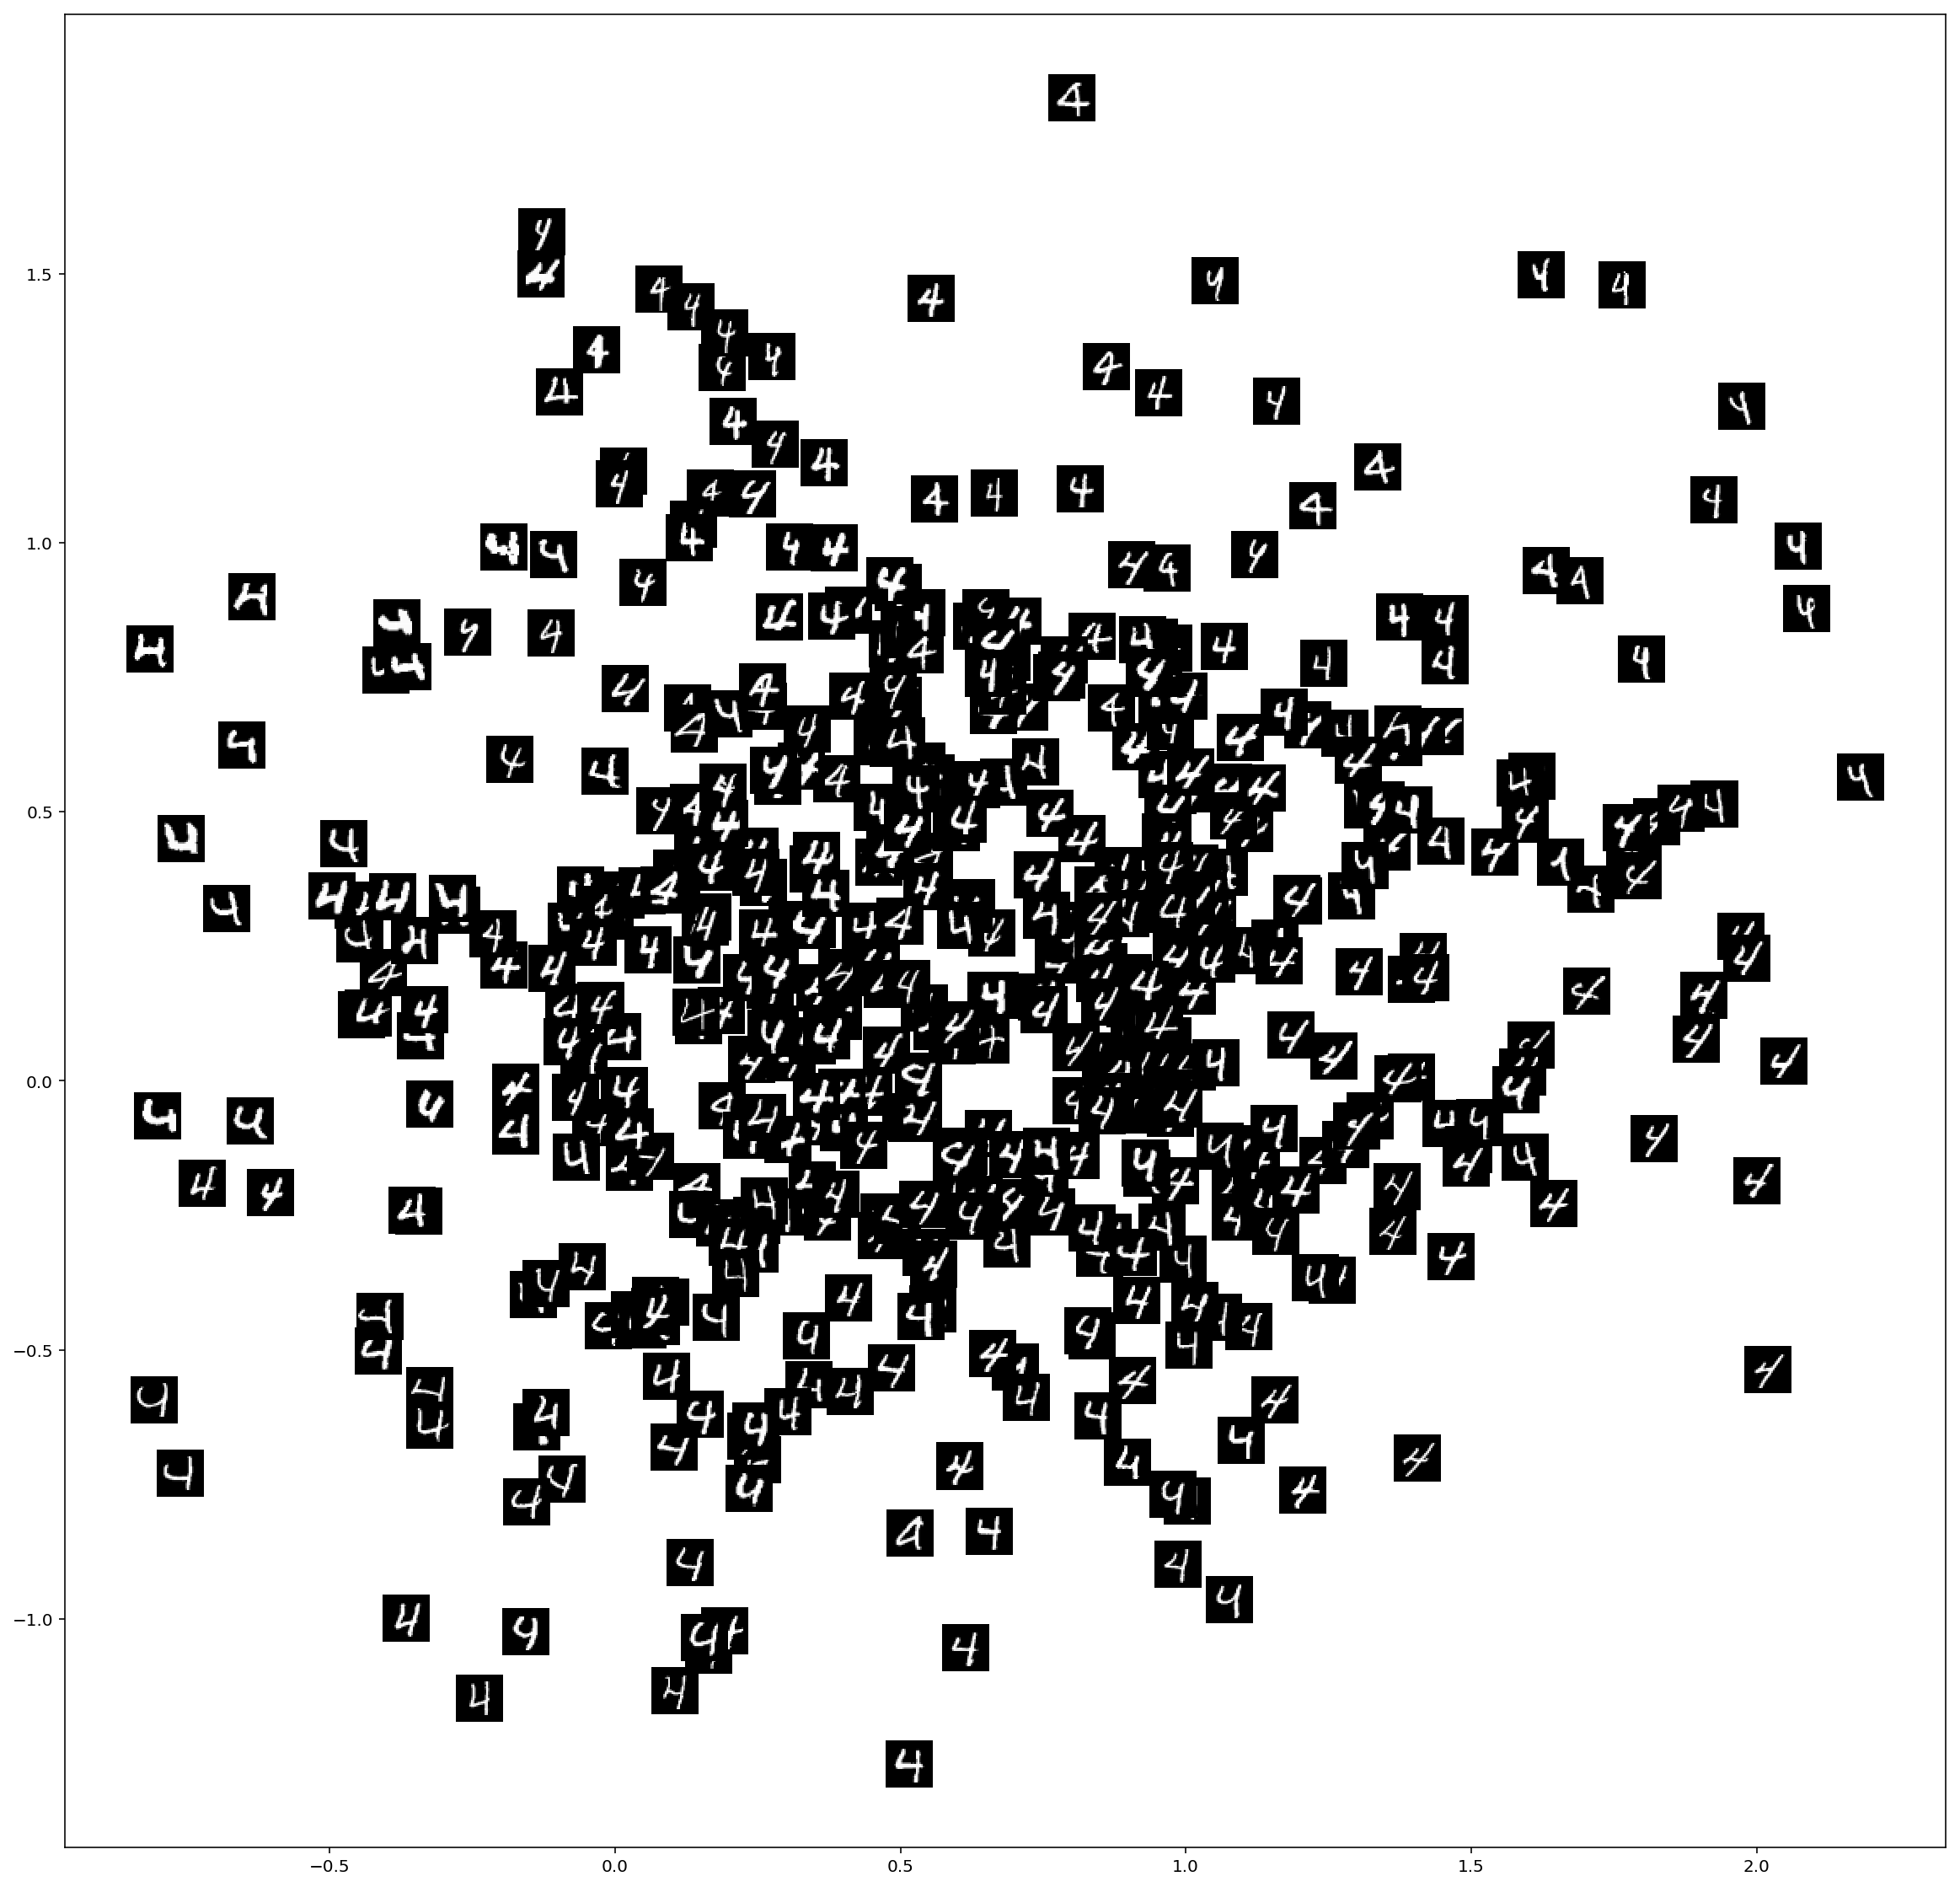

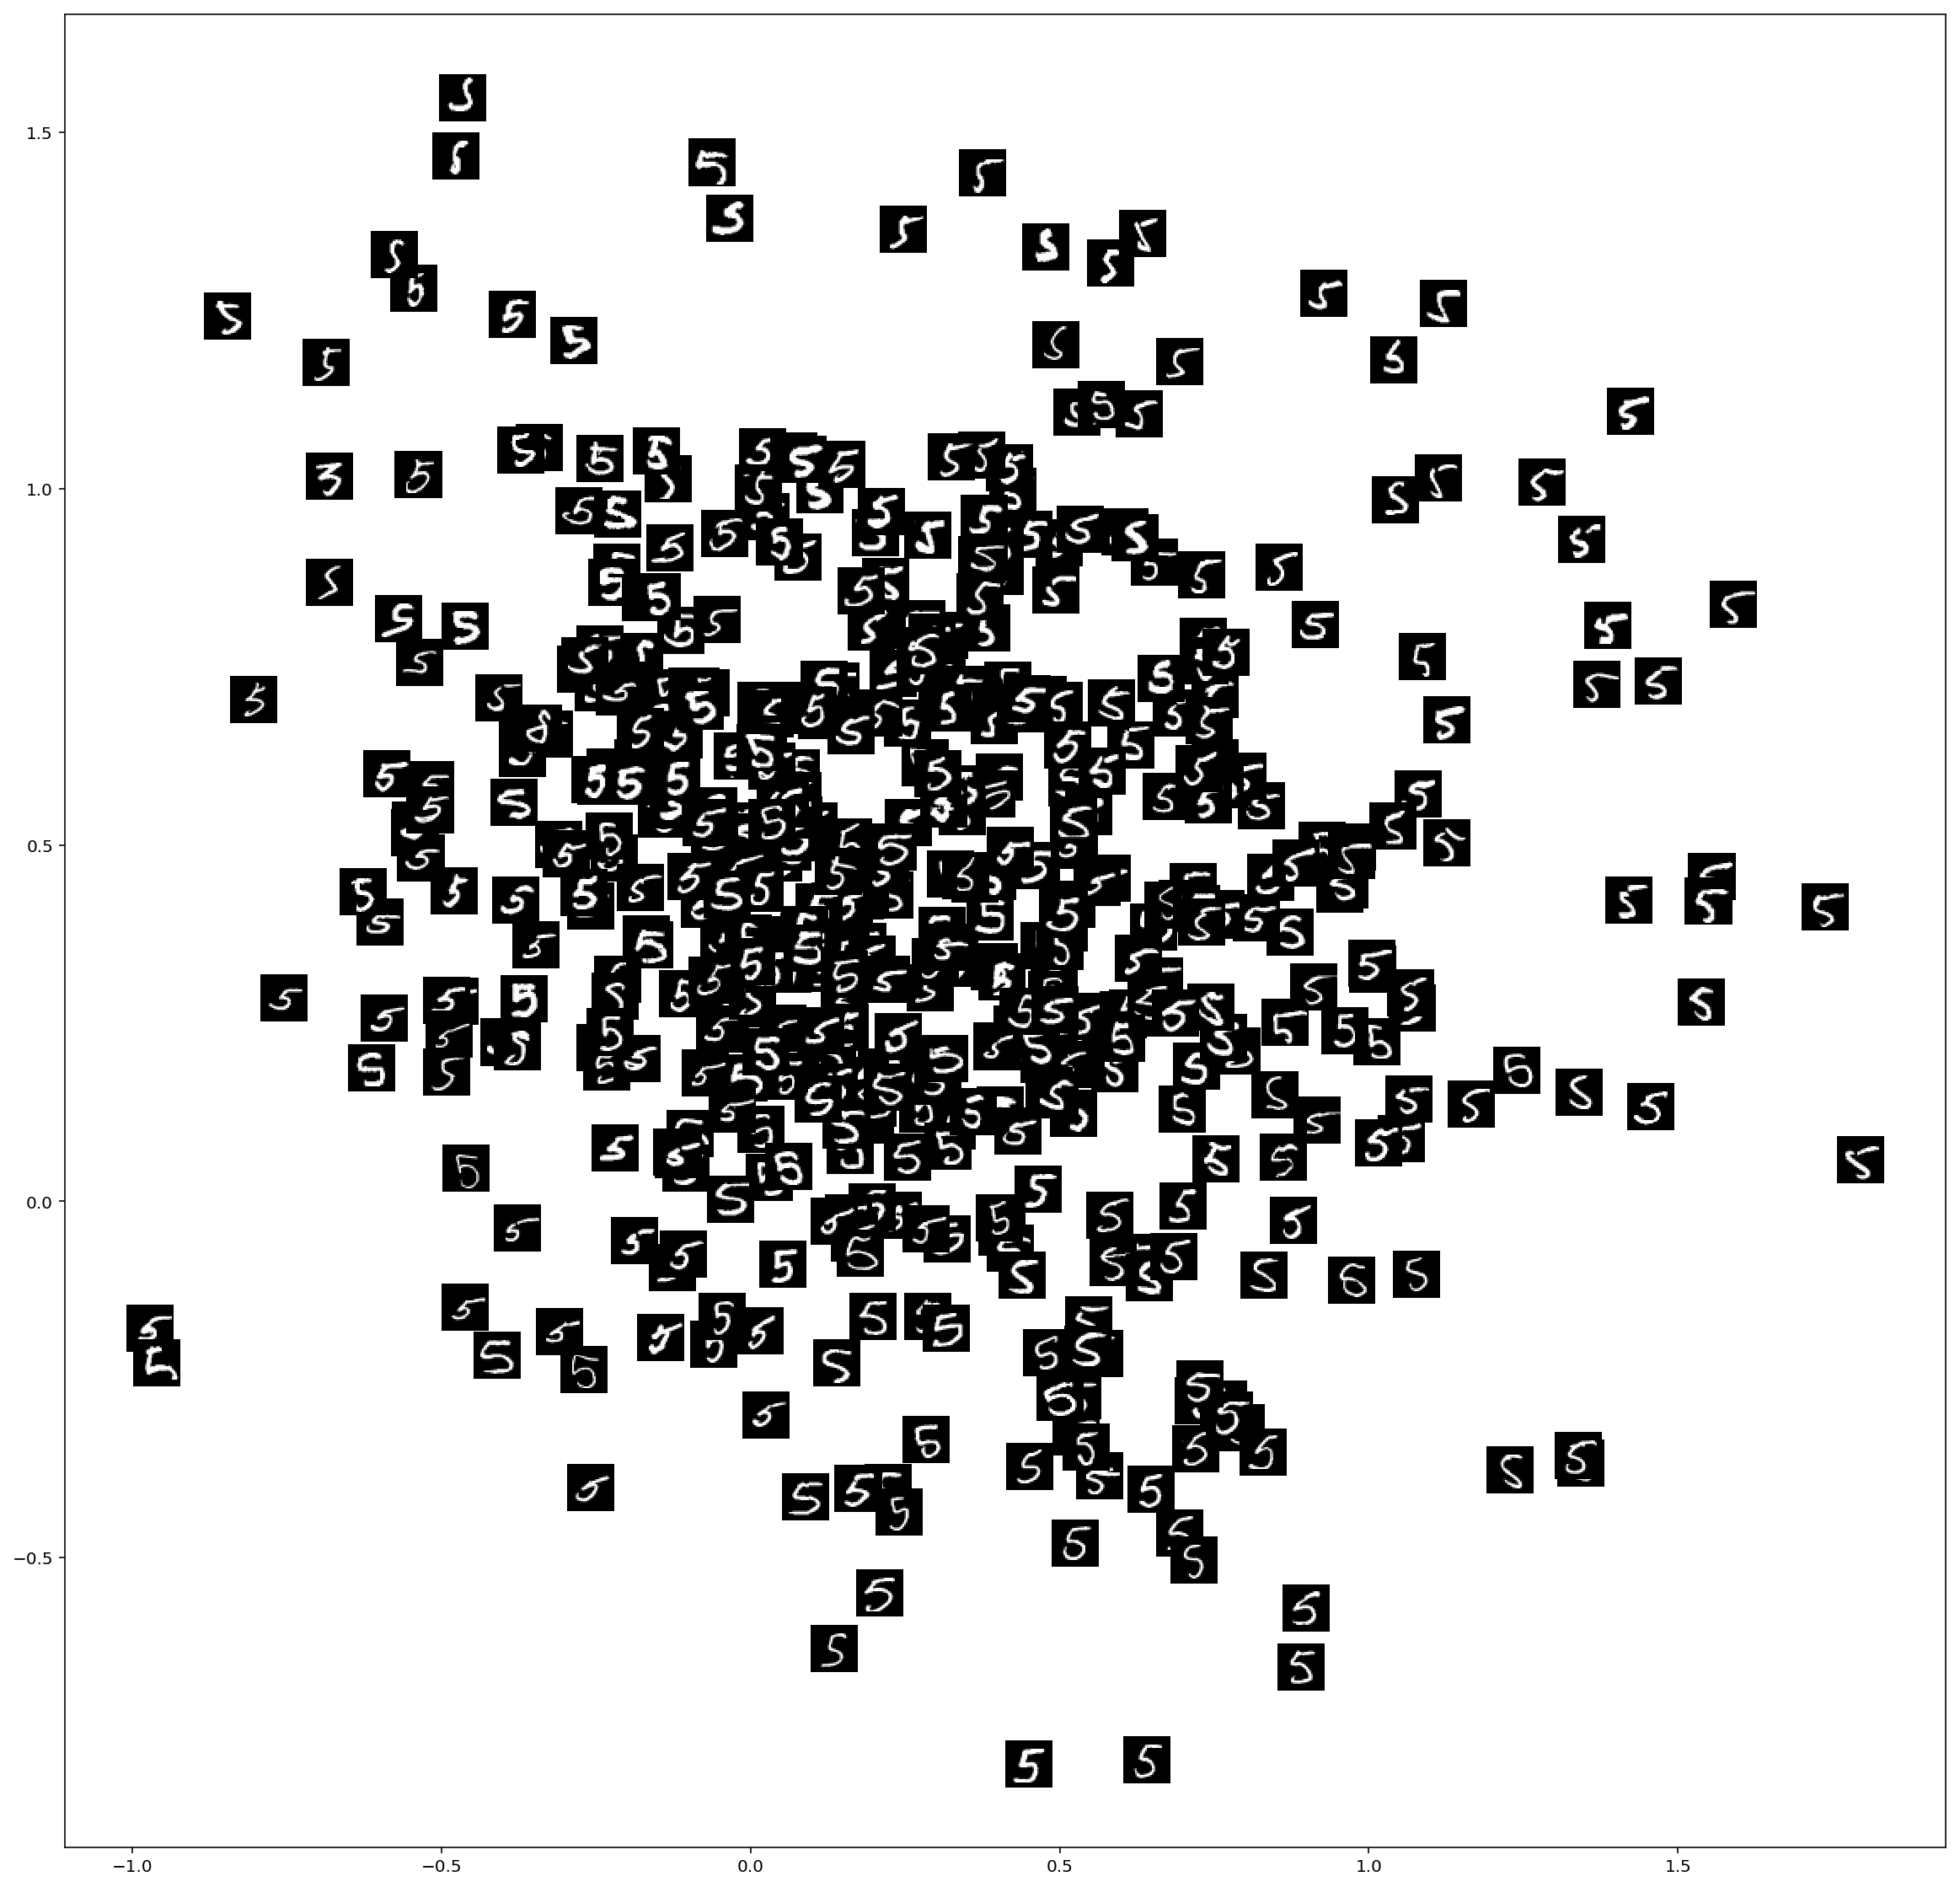

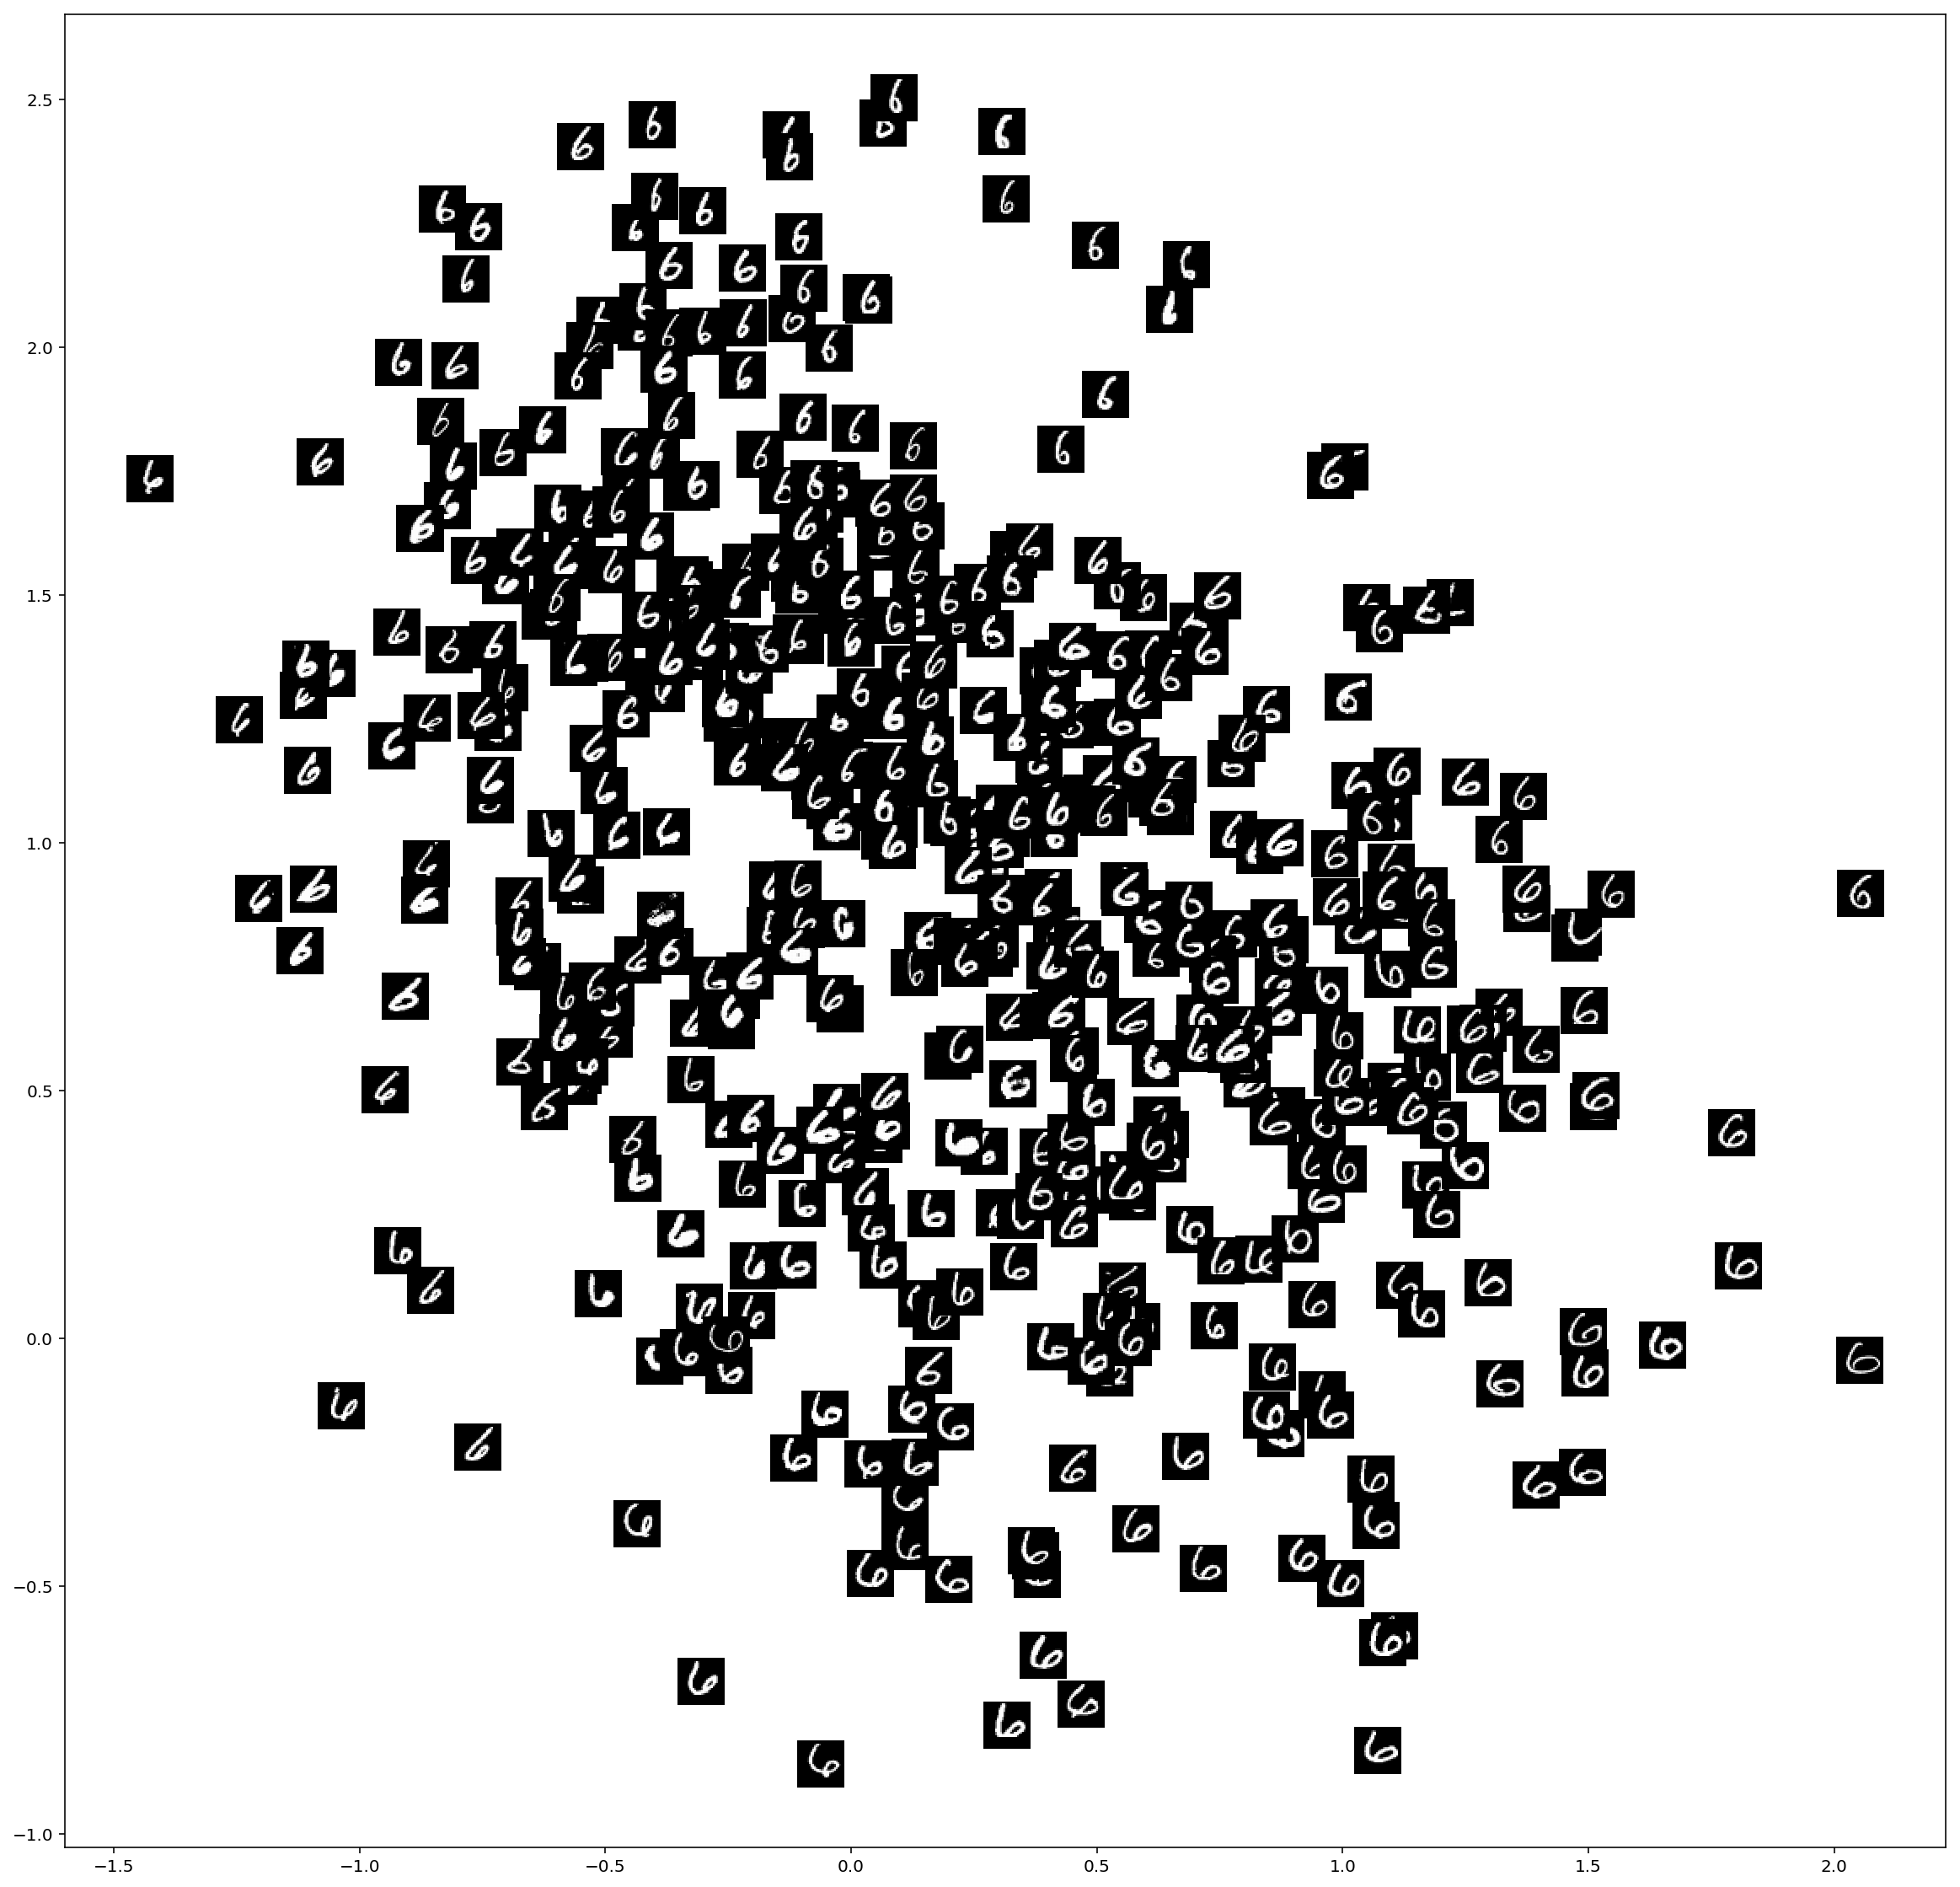

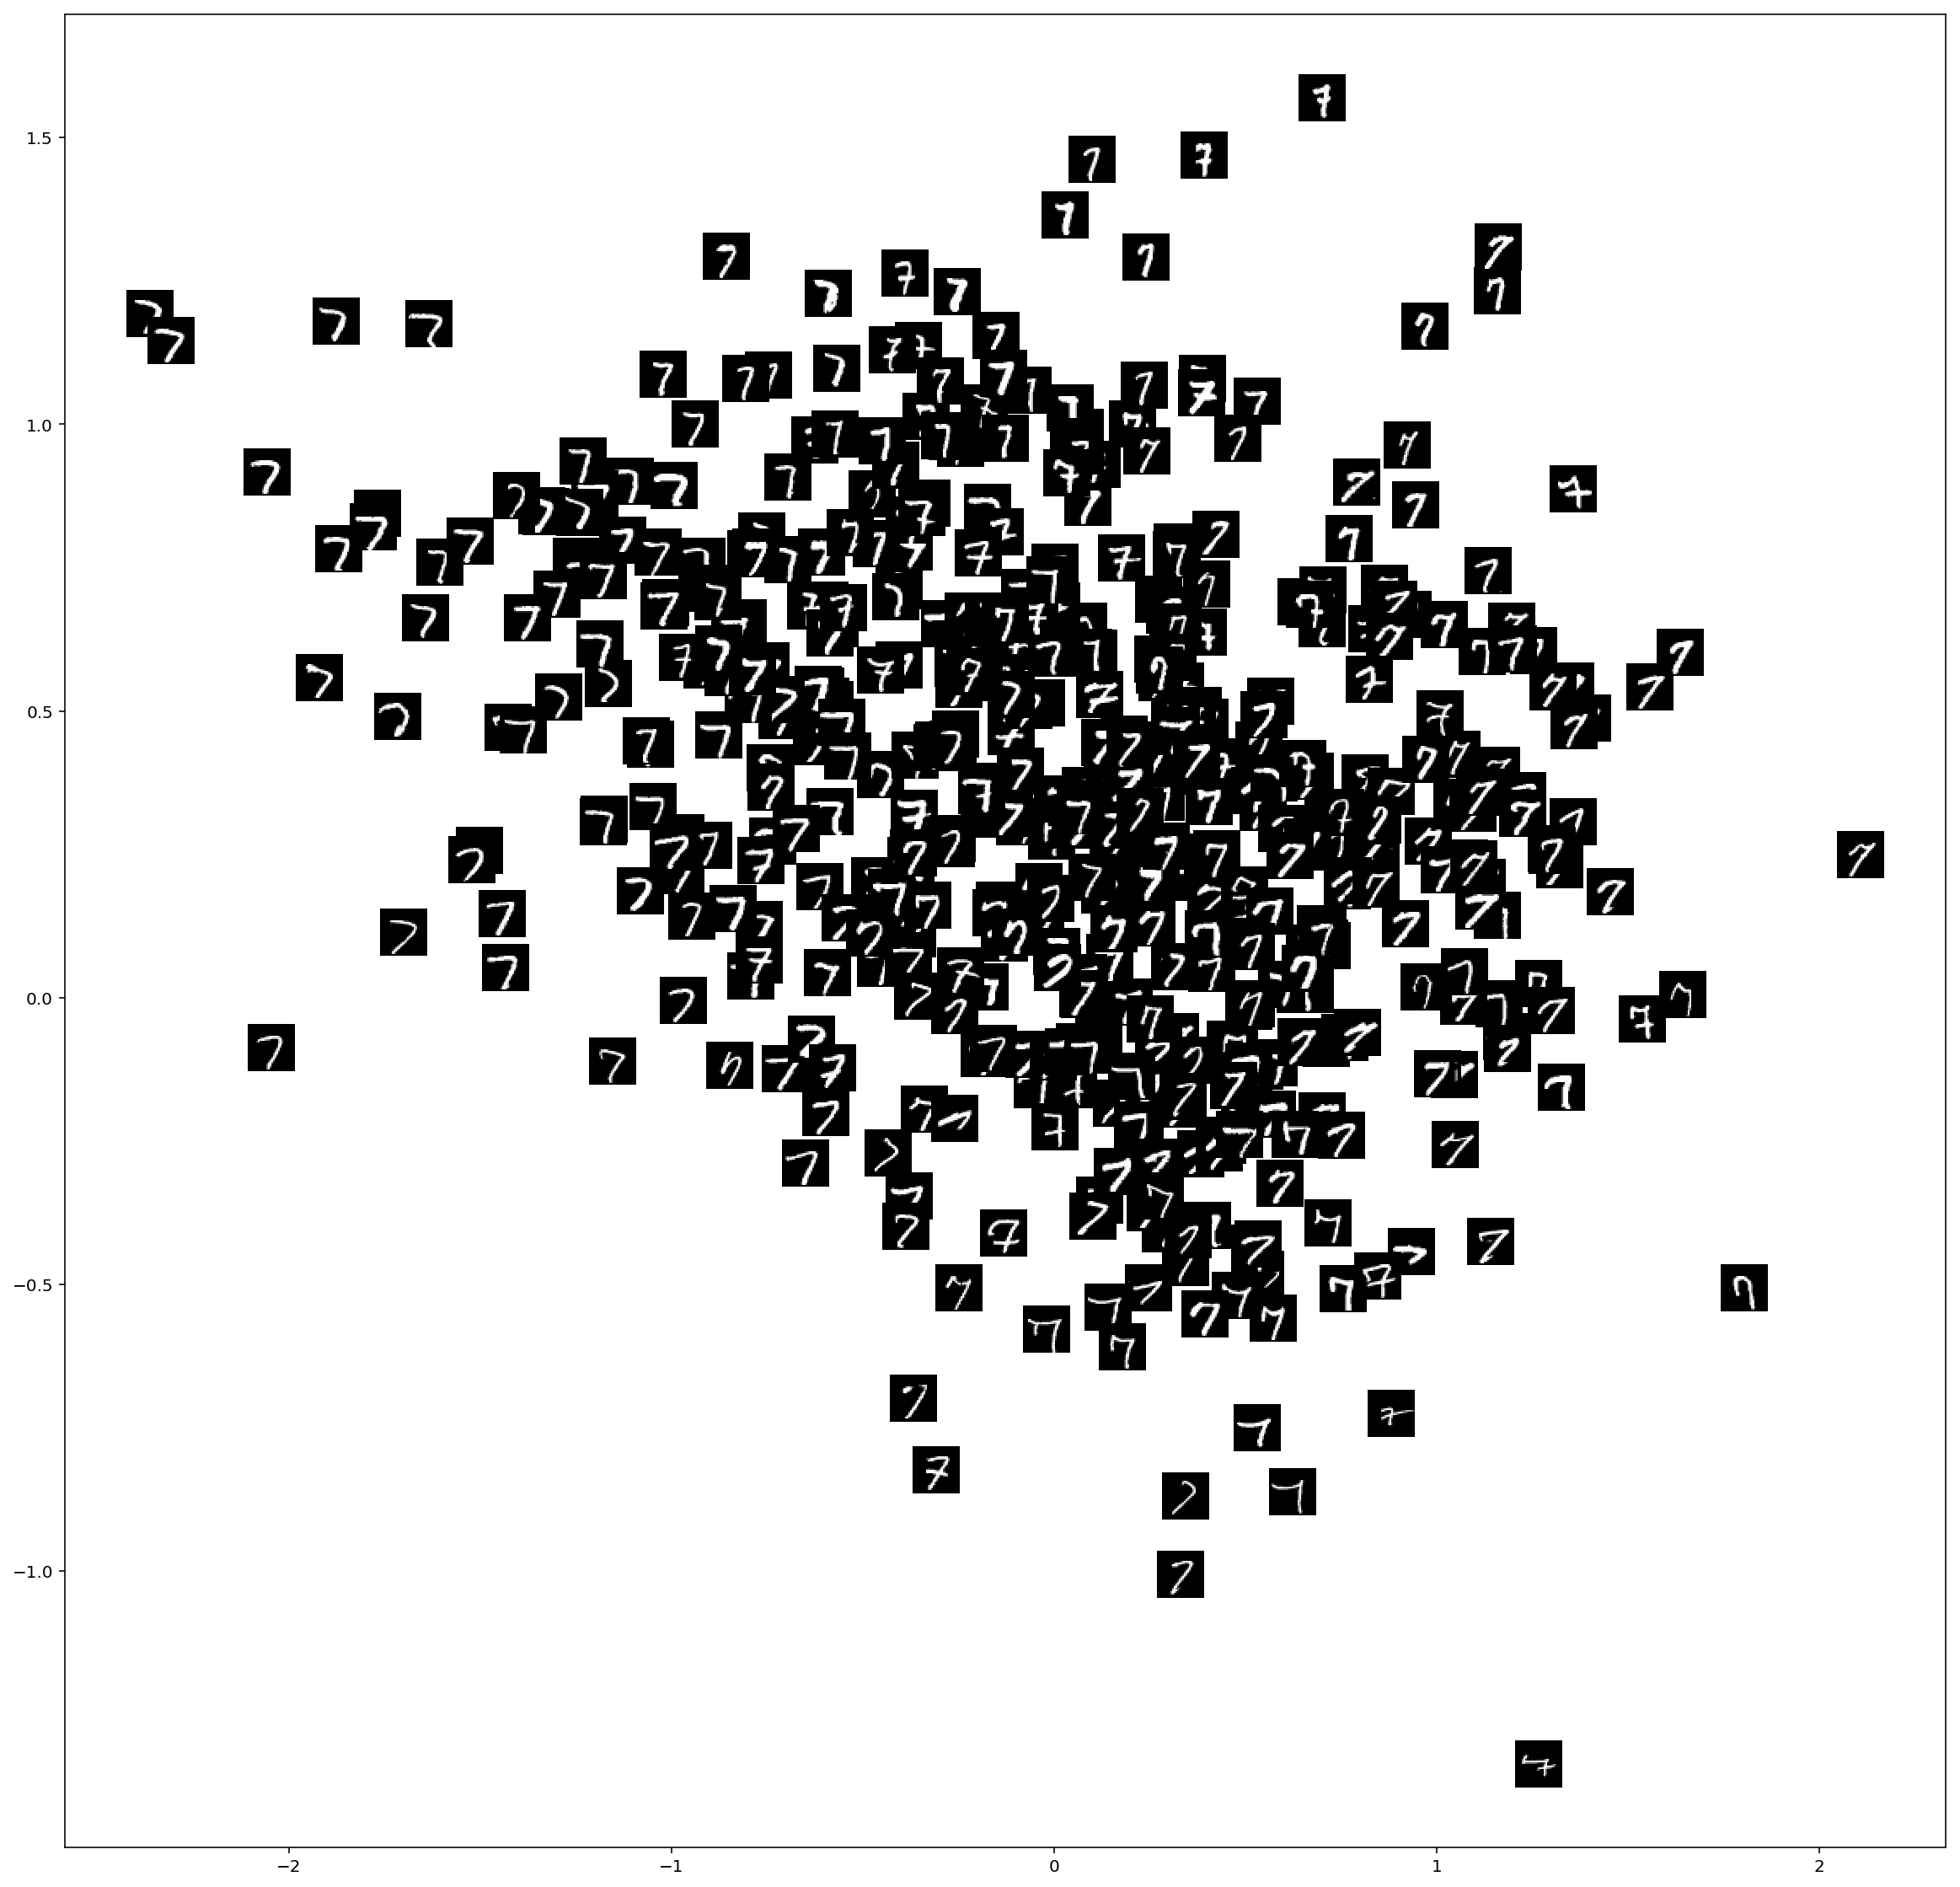

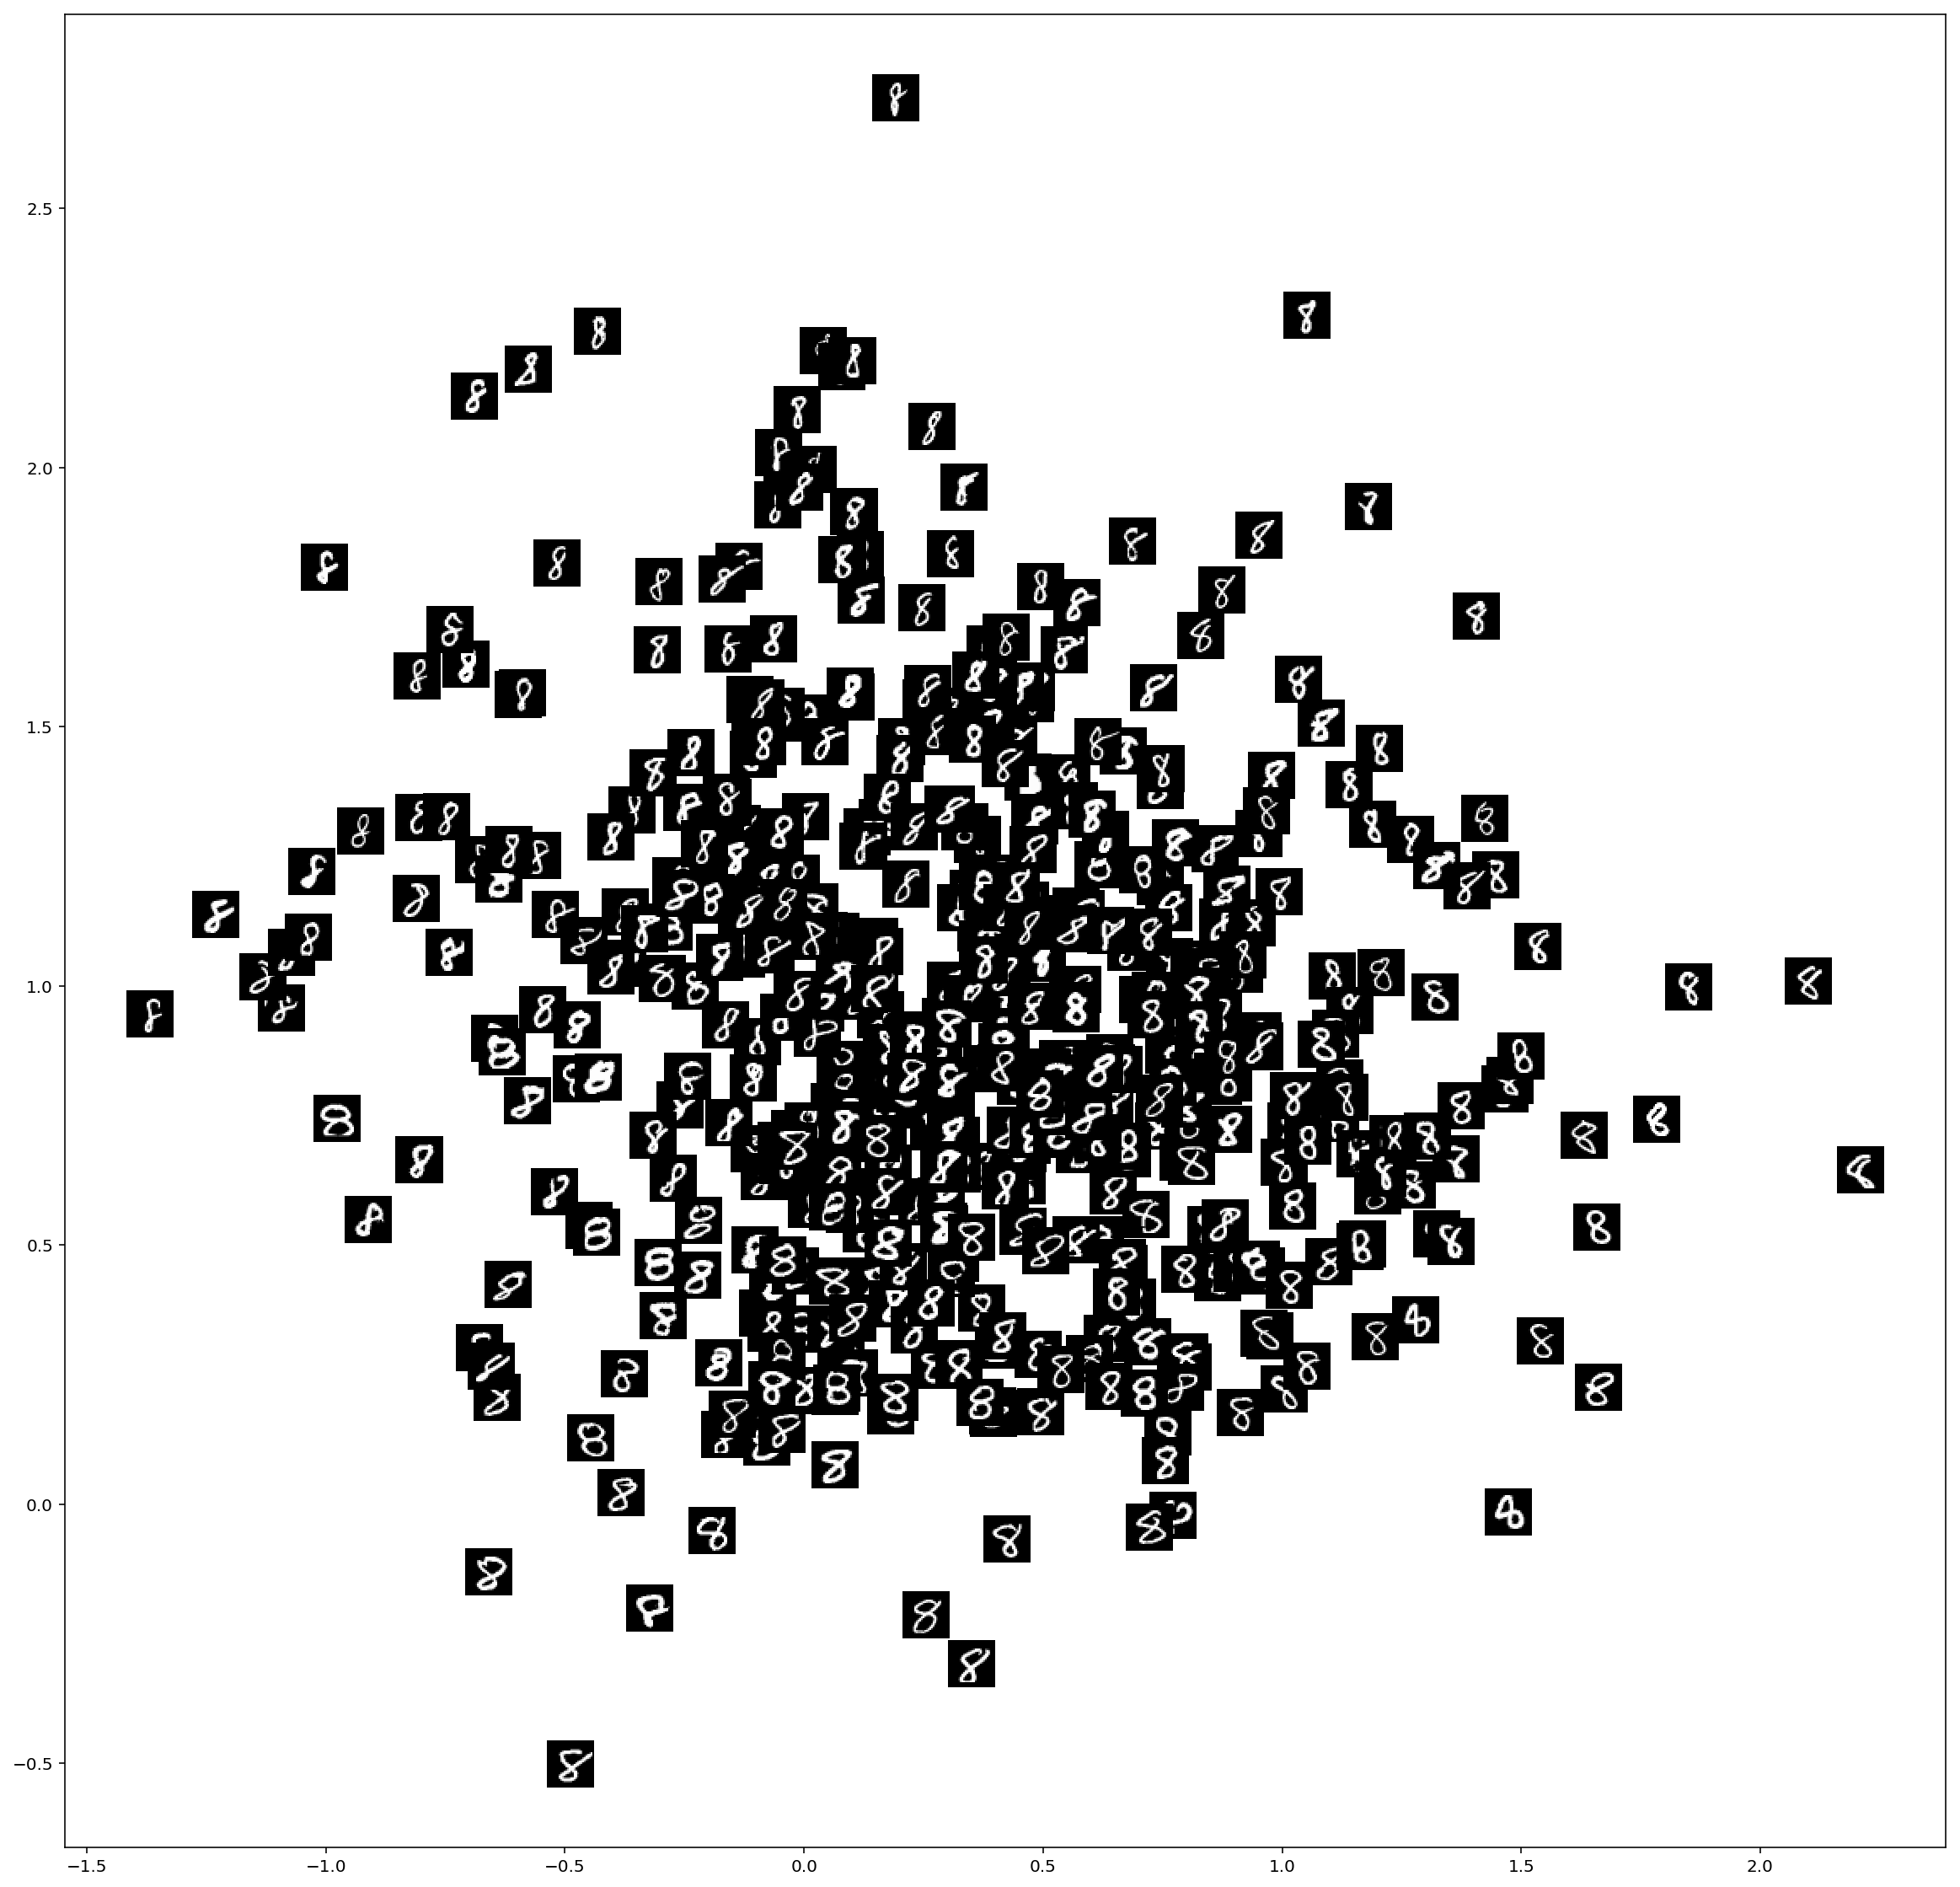

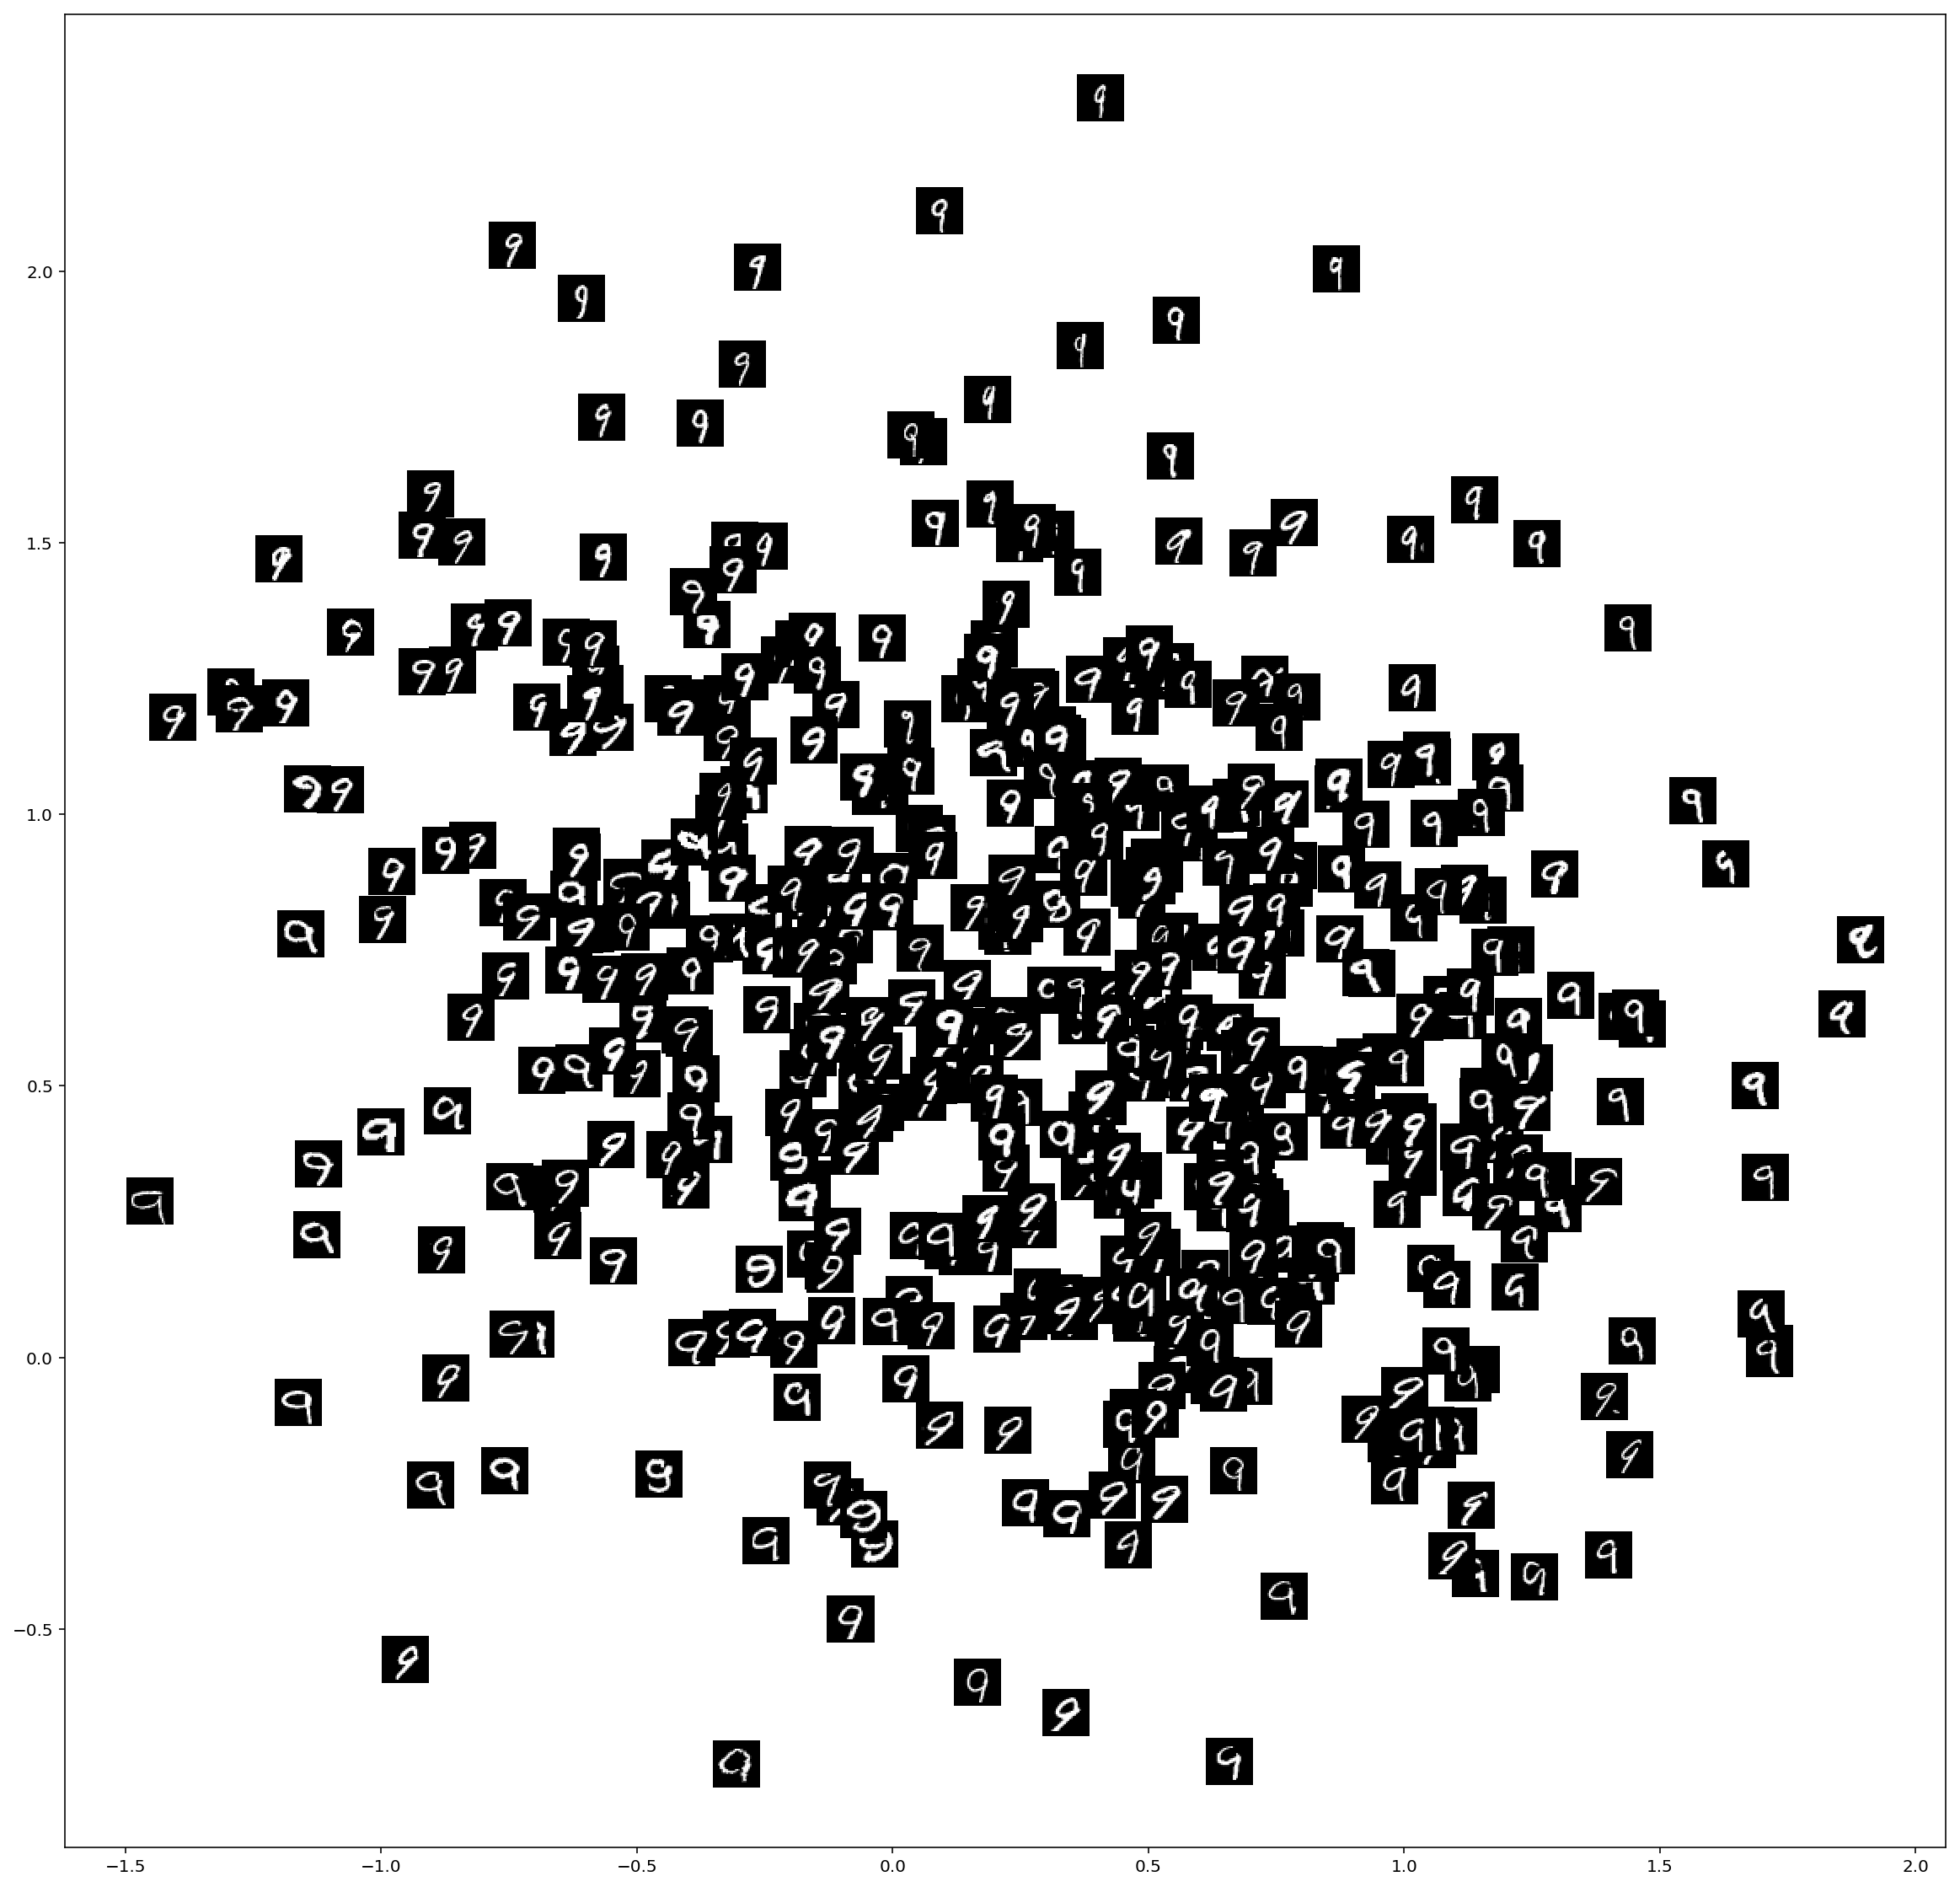

In [60]:
for i in range(10):

    c_num = i

    subset_num_emb = []
    subset_num_img = []

    for lab,emb,img in zip(labels,embeddings_array,imgs):
        if lab == c_num:
            subset_num_emb.append(emb)
            subset_num_img.append(img)

    subset_num_emb = np.array(subset_num_emb)

    visualize_scatter_with_images(subset_num_emb[:500], subset_num_img[:500] ,img_name='2D_SNE_CVAE_%d.eps'%c_num)

# Test Data

In [1]:
from torch.autograd import Variable

import VAE_NN
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import torch

from torch.optim import Adam, Adagrad

import seaborn as sns

import time

In [2]:
test = VAE_NN.VAE_Net(latent_size=20,conditional=False,fast=False)

In [3]:
test.cuda()

VAE_Net(
  (ei): Linear(in_features=784, out_features=500)
  (em): Linear(in_features=500, out_features=20)
  (ev): Linear(in_features=500, out_features=20)
  (di): Linear(in_features=20, out_features=500)
  (dom): Linear(in_features=500, out_features=784)
)

In [4]:
optimizer = Adam(test.parameters(),lr=1e-3)

In [5]:
train_data,test_data = VAE_NN.get_data_loaders(b_size=100)

In [10]:
len(test_data)

100

In [6]:
t = time.time()
ep = 10
VAE_NN.train(test,optimizer,train_data, VAE_NN.elbo_loss, epochs = ep,test_loader=test_data,summary='./experiment_p/')
t_e = time.time() - t
print('Seconds for %d epcohs: %d' % (ep,t_e))

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 54869.972656
Train Epoch: 0 [10000/60000 (17%)]	Loss: 19746.742188
Train Epoch: 0 [20000/60000 (33%)]	Loss: 15931.395508
Train Epoch: 0 [30000/60000 (50%)]	Loss: 15412.611328
Train Epoch: 0 [40000/60000 (67%)]	Loss: 14774.832031
Train Epoch: 0 [50000/60000 (83%)]	Loss: 16099.511719


 10%|█         | 1/10 [00:09<01:24,  9.44s/it]

140.48096611328126
Train Epoch: 1 [0/60000 (0%)]	Loss: 13619.388672
Train Epoch: 1 [10000/60000 (17%)]	Loss: 14568.781250
Train Epoch: 1 [20000/60000 (33%)]	Loss: 13552.509766
Train Epoch: 1 [30000/60000 (50%)]	Loss: 14426.375977
Train Epoch: 1 [40000/60000 (67%)]	Loss: 12964.644531
Train Epoch: 1 [50000/60000 (83%)]	Loss: 12969.929688


 20%|██        | 2/10 [00:17<01:11,  8.99s/it]

130.00477333984375
Train Epoch: 2 [0/60000 (0%)]	Loss: 12980.544922
Train Epoch: 2 [10000/60000 (17%)]	Loss: 12324.654297
Train Epoch: 2 [20000/60000 (33%)]	Loss: 13667.308594
Train Epoch: 2 [30000/60000 (50%)]	Loss: 13114.415039
Train Epoch: 2 [40000/60000 (67%)]	Loss: 12641.761719
Train Epoch: 2 [50000/60000 (83%)]	Loss: 13034.806641


 30%|███       | 3/10 [00:26<01:01,  8.85s/it]

128.90518603515625
Train Epoch: 3 [0/60000 (0%)]	Loss: 13752.989258
Train Epoch: 3 [10000/60000 (17%)]	Loss: 12246.601562
Train Epoch: 3 [20000/60000 (33%)]	Loss: 12920.976562
Train Epoch: 3 [30000/60000 (50%)]	Loss: 13113.144531
Train Epoch: 3 [40000/60000 (67%)]	Loss: 12090.299805
Train Epoch: 3 [50000/60000 (83%)]	Loss: 12238.191406


 40%|████      | 4/10 [00:35<00:52,  8.81s/it]

124.8887841796875
Train Epoch: 4 [0/60000 (0%)]	Loss: 11762.494141
Train Epoch: 4 [10000/60000 (17%)]	Loss: 13355.751953
Train Epoch: 4 [20000/60000 (33%)]	Loss: 12770.650391
Train Epoch: 4 [30000/60000 (50%)]	Loss: 13006.154297
Train Epoch: 4 [40000/60000 (67%)]	Loss: 12170.341797
Train Epoch: 4 [50000/60000 (83%)]	Loss: 12075.519531


 50%|█████     | 5/10 [00:44<00:44,  8.87s/it]

121.22238447265624
Train Epoch: 5 [0/60000 (0%)]	Loss: 12391.885742
Train Epoch: 5 [10000/60000 (17%)]	Loss: 12405.632812
Train Epoch: 5 [20000/60000 (33%)]	Loss: 12265.041016
Train Epoch: 5 [30000/60000 (50%)]	Loss: 12377.813477
Train Epoch: 5 [40000/60000 (67%)]	Loss: 13605.837891
Train Epoch: 5 [50000/60000 (83%)]	Loss: 12152.521484


 60%|██████    | 6/10 [00:53<00:35,  8.90s/it]

120.44139804687501
Train Epoch: 6 [0/60000 (0%)]	Loss: 12015.898438


Process Process-13:
Traceback (most recent call last):
  File "/home/pjb208/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/pjb208/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pjb208/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/pjb208/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/pjb208/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/datasets/mnist.py", line 76, in __getitem__
    img = self.transform(img)
  File "/home/pjb208/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 61, in __call__
    return F.to_tens

Train Epoch: 6 [10000/60000 (17%)]	Loss: 12676.955078


KeyboardInterrupt: 